# Problem Definition

Use historical boxscores to predict an NBA player's Points Per Second (PPS) in a single game. In conjunction with the predicted NBA player's Seconds Played (SP) will be used to predict the total points of a player in a single game.

### Usage

- The final points projection will be used along other stat projections to predict a player's Daily Fantasy Sports (DFS) Fantasy Score. 
- The projection will also be used to bet on vegas lines.

# Setup

Import the necessary libraries

In [1]:
# for data
import pandas as pd
import numpy as np
from datetime import datetime, timedelta
from pyNBA.Data.data import QueryData
from pyNBA.Models.helpers import CleanData
import math

# for features
from pyNBA.Models.features import FeatureCreation
from pyNBA.Models.cluster import Cluster, Evaluate
from sklearn.feature_selection import SelectFromModel
from sklearn.feature_selection import RFE

# for plotting
import matplotlib.pyplot as plt
import seaborn as sns
from research import Helpers
from statsmodels.graphics.api import abline_plot

# for statistical tests
from scipy.stats import shapiro
import pingouin as pg

# for machine learning
from sklearn import model_selection, preprocessing, ensemble, neighbors, linear_model, svm, neural_network, metrics
import xgboost as xgb
from catboost import CatBoostRegressor, Pool
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

# for explainer
from lime import lime_tabular

# misc
import warnings
warnings.filterwarnings('ignore')
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

/Users/brandonshimiaie/Projects/NBAvenv/lib/python3.7/site-packages/outdated/utils.py:18: OutdatedPackageWarning: The package pingouin is out of date. Your version is 0.3.3, the latest is 0.3.4.
Set the environment variable OUTDATED_IGNORE=1 to disable these warnings.
  **kwargs


# Factor Determination
Determine the factors that influence a player's Points Per Second (PPS).

- Historical PPS
    - Season average
    - Recent performances (hot streaks)
    - Home vs. Away
    - Start vs. Bench
    - Rest
    - Historical Attempts Per Second (APS) and Points Per Second (PPS)


- Defense
    - Defensive PPS allowed
        - Starters vs. Bench players
        - By position
        - By cluster
    - Vegas game total

        
- Injuries
    - APS of players playing vs average APS of team
    - Player PPS/APS by starting lineup

# Data Analysis
Summarize the characteristics of the dataset.

First, I will pull the boxscore data and drop the unessesary rows.

In [2]:
query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

# we are only interested in the boxscores of healthy and non-resting players
boxscores = clean_data.drop_rows_player_injured(boxscores)
boxscores = clean_data.drop_rows_player_rest(boxscores)

pd.set_option('display.max_columns', None)
display(boxscores.head())

/Users/brandonshimiaie/Projects/sqlite/db/nba.db
2.6.0


,PLAYERID,TEAM,GAMEID,OPP_TEAM,COMMENT,START,SECONDSPLAYED,PTS,FGM,FGA,FG3M,FG3A,FTM,FTA,PTS_OFF_TOV,PTS_2ND_CHANCE,PTS_FB,PTS_PAINT,PCT_AST_2PM,PCT_AST_3PM,OREB,OREB_PCT,DREB,DREB_PCT,AST,AST_PCT,AST_RATIO,STL,BLK,TOV,PF,PLUSMINUS,USG_PCT,PACE,ID_x,SEASON,DATE,HTM,VTM,W,ID_y,NAME,POSITION,SCHOOL,COUNTRY,HEIGHT,WEIGHT,DRAFTYEAR,DRAFTROUND,DRAFTNUMBER,BIRTHDATE
0,203906,ORL,0021400001,NOP,,0,179,4,2,2,0,0,0,2,0,0,2,4,0.500,0.0,0,0.000,1.0,0.333,0,0.000,0.0,0,0,0,1,4,0.300,112.63,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,203906,Devyn Marble,Forward,Iowa,USA,78,200,2014,2,56,1992-09-21
1,2584,ORL,0021400001,NOP,,0,247,0,0,1,0,0,0,0,0,0,0,0,0.000,0.0,1,0.250,1.0,0.100,0,0.000,0.0,0,0,0,0,-3,0.100,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,2584,Willie Green,Guard,Detroit Mercy,USA,75,205,2003,2,41,1981-07-28
2,202690,NOP,0021400001,ORL,,0,1068,2,0,6,0,3,2,2,0,0,0,0,0.000,0.0,0,0.000,0.0,0.000,2,0.133,22.2,1,0,0,3,3,0.146,98.43,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202690,Jimmer Fredette,Guard,Brigham Young,USA,74,195,2011,1,10,1989-02-25
3,202699,ORL,0021400001,NOP,,1,2192,25,9,18,1,2,6,6,6,5,8,16,0.625,1.0,2,0.048,6.0,0.111,0,0.000,0.0,1,0,4,2,-4,0.289,93.28,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,202699,Tobias Harris,Forward,Tennessee,USA,80,226,2011,1,19,1992-07-15
4,201950,NOP,0021400001,ORL,,1,1622,8,4,11,0,3,0,0,2,2,2,6,0.250,0.0,0,0.000,2.0,0.067,4,0.190,23.5,3,1,2,2,9,0.188,94.99,0021400001,2014-15,2014-10-28,NOP,ORL,ORL,201950,Jrue Holiday,Guard,UCLA,USA,75,205,2009,1,17,1990-06-12


I need to determine the type of each column, as well as the proportion of missing data.

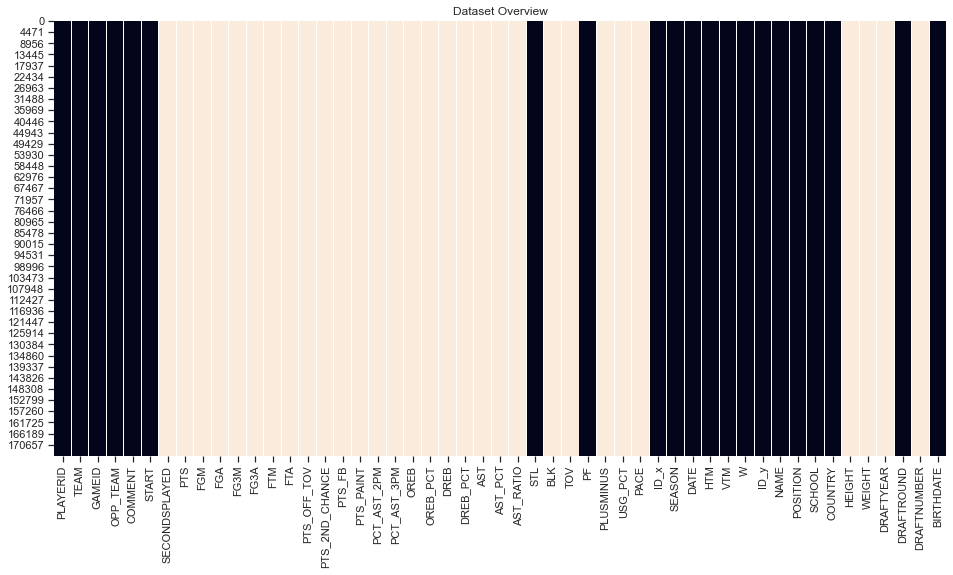

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [3]:
helpers = Helpers()

plt.rcParams["figure.figsize"] = (16, 8)
helpers.visualize_dataframe(boxscores)

Great, there is no missing data.

Next I will create the column of our dependant variable, $PPS$.

In [4]:
y = 'Y'
boxscores[y] = boxscores['PTS']/boxscores['SECONDSPLAYED']

Let's take a look at the distribution of values of our dependant variable. I will use a histogram to to visualize the probability density distribution of the outcomes of $Y$, and a box plot to graph data groups and outliers.

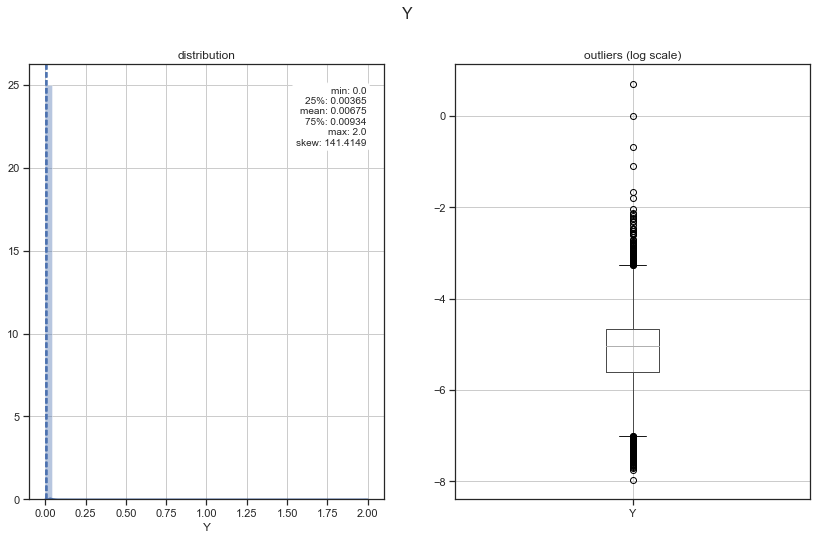

In [5]:
helpers.visualize_variable_distribution(boxscores, y, figsize=(14, 8))

Yikes.

There is clearly an abundance of outliers on the right side of the distribution. The maximum $PPS$ in our sampe is a (very impressive) 2.0.

My first guess of the cause of the plethora of outliers is that those outliers come from boxscores in which the player played very few seconds. For example, if a player played for 8 seconds, and scored 2 points, his $PPS$ would be 0.25. That would be an outlier in our distribtion.

Below shows the $PPS$ distribution across different playing times.

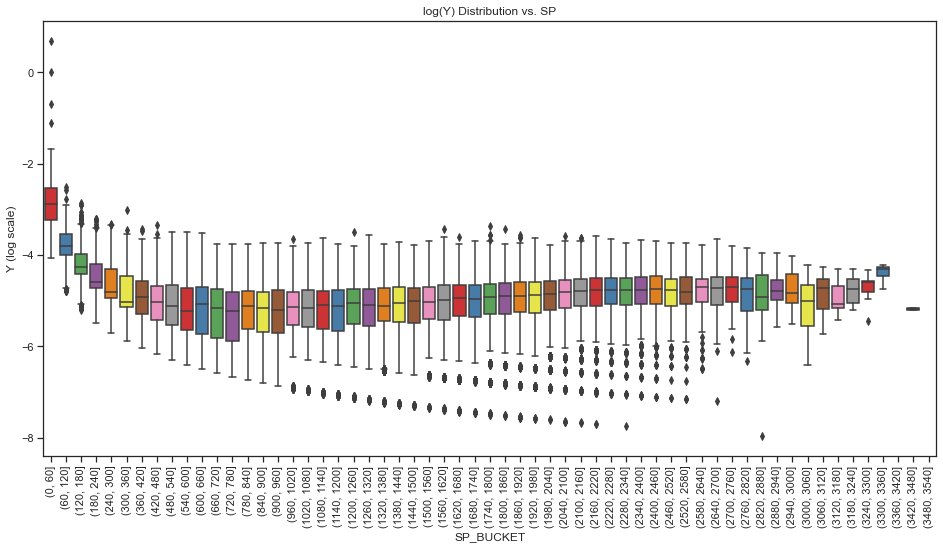

In [6]:
sp_max = boxscores['SECONDSPLAYED'].max()
max_bucket = int(60 * round(float(sp_max)/60))
buckets = [i for i in range(0, max_bucket, 60)]

temp = boxscores[[y, 'SECONDSPLAYED']]
temp['Y (log scale)'] = temp[y].apply(lambda x: np.log(x) if x > 0 else np.nan)
temp['SP_BUCKET'] = pd.cut(temp['SECONDSPLAYED'], buckets)

ax = sns.boxplot(x="SP_BUCKET", y="Y (log scale)", data=temp, palette="Set1")
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('log(Y) Distribution vs. SP')
plt.show()
plt.close()

It seems as though the outliers are coming from the (0, 60] seconds played bucket. Let's remove those values from our set of outcomes, and replot the distributions.

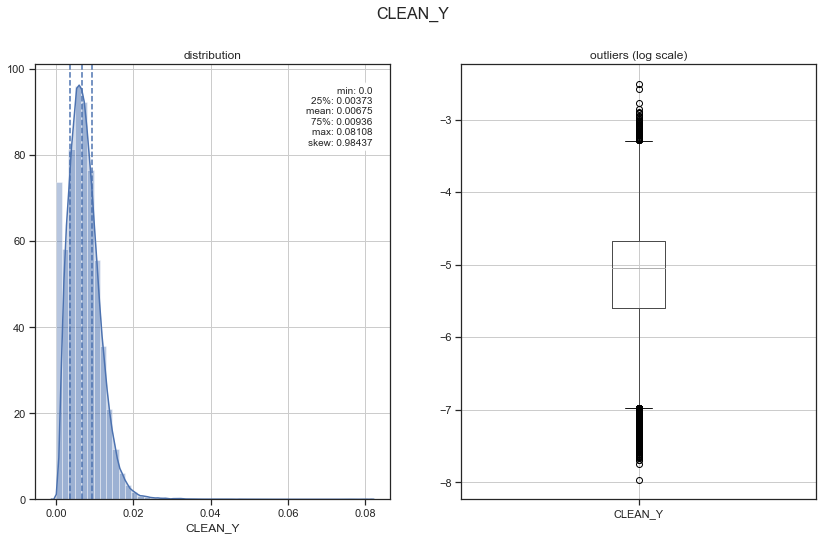

In [7]:
sp_threshold = 60

clean_y = 'CLEAN_Y'
boxscores[clean_y] = boxscores[y]
boxscores.loc[boxscores['SECONDSPLAYED'] <= sp_threshold, clean_y] = np.nan
helpers.visualize_variable_distribution(boxscores, clean_y, figsize=(14, 8))

This distribution looks better. We have far less positive outliers.

However, the distribution is still very skewed right and contains many outliers much higher than our mean.

Let's try looking at the distribtion of log outcomes.

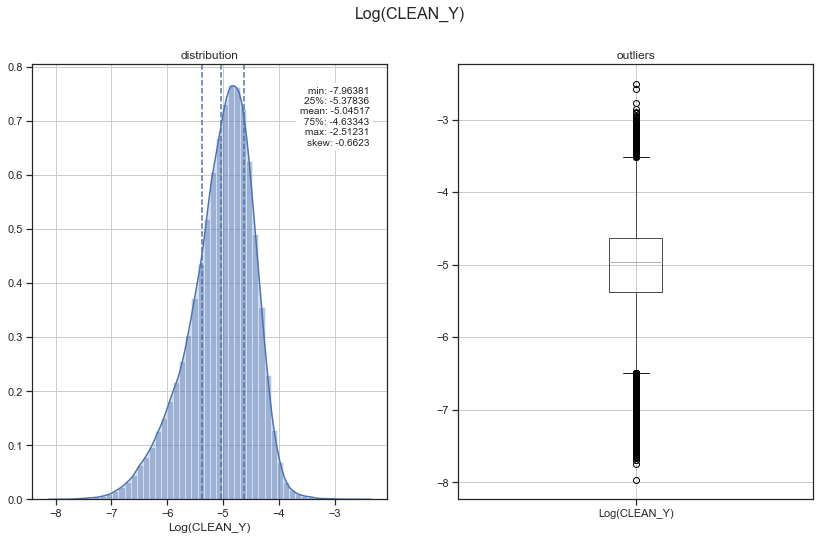

In [8]:
boxscores['Log(CLEAN_Y)'] = np.log(boxscores[clean_y])
boxscores['Log(CLEAN_Y)'] = boxscores['Log(CLEAN_Y)'].replace(-np.inf, np.nan)

helpers.visualize_variable_distribution(boxscores, 'Log(CLEAN_Y)', log_boxplot=False, figsize=(14, 8))

In [9]:
stat, p = shapiro(boxscores['Log(CLEAN_Y)'].dropna())
print(stat, p)

0.9733001589775085 0.0


Much better.

The distribution now contains a roughly equal amount of outliers on the left and right side, is less skewed, and is statistically normal.

# Feature Engineering
Create new features from raw data using domain knowlege.

In [10]:
regressors = []
categorical_regressors = []

### Historical PPS
First, I will create features based on a player's historical $PPS$.

I will start by calculating the running $PPS$ of a player in a season.

In [11]:
feature_creation = FeatureCreation()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y'
)

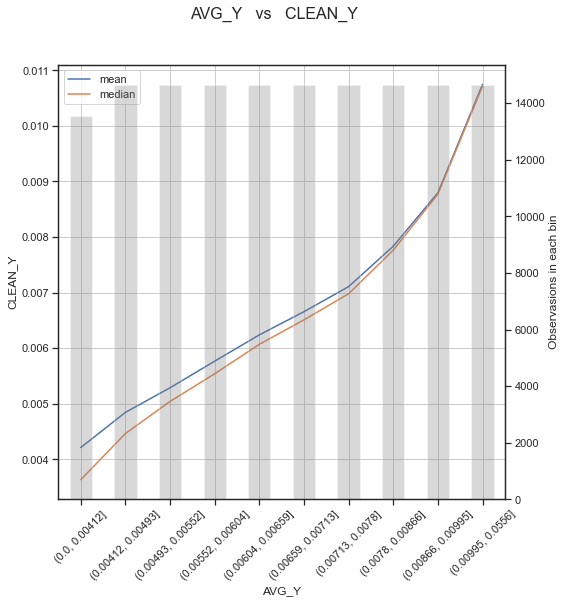

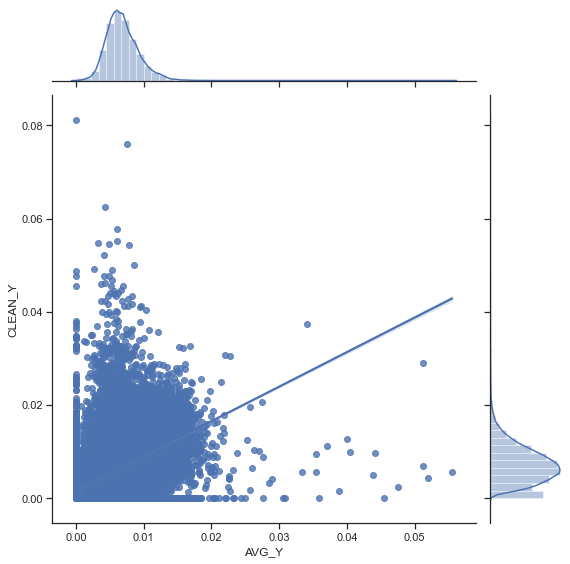

In [12]:
helpers.visualize_numeric_x_vs_y(boxscores.loc[boxscores['AVG_Y'] < 0.1], 'AVG_Y', clean_y, figsize=(8, 8))

In [13]:
regressors.append('AVG_Y')

Next, I will calculate the $PPS$ of a player in the previous games against the same opposing team in the same season.

In [14]:
boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'OPP_TEAM', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_OPP_TEAM'
)
regressors.append('AVG_Y_OPP_TEAM')

Do more recent Y values within a season matter more than previous ones?

To answer this, first I will calculate the Autocorrelation of $Y$ and previous lags of $Y$:

$$ ACF(Y_{0}, Y_{i}) $$ <br>

Then, I will calculate the Partial Autocorrelation between $Y$ and previous lags of $Y$, using the lags in between as covariates:

$$ PACF(Y_{0}, Y_{i}  |  \{Y_{j}\}_{0<j<i}) $$ <br>

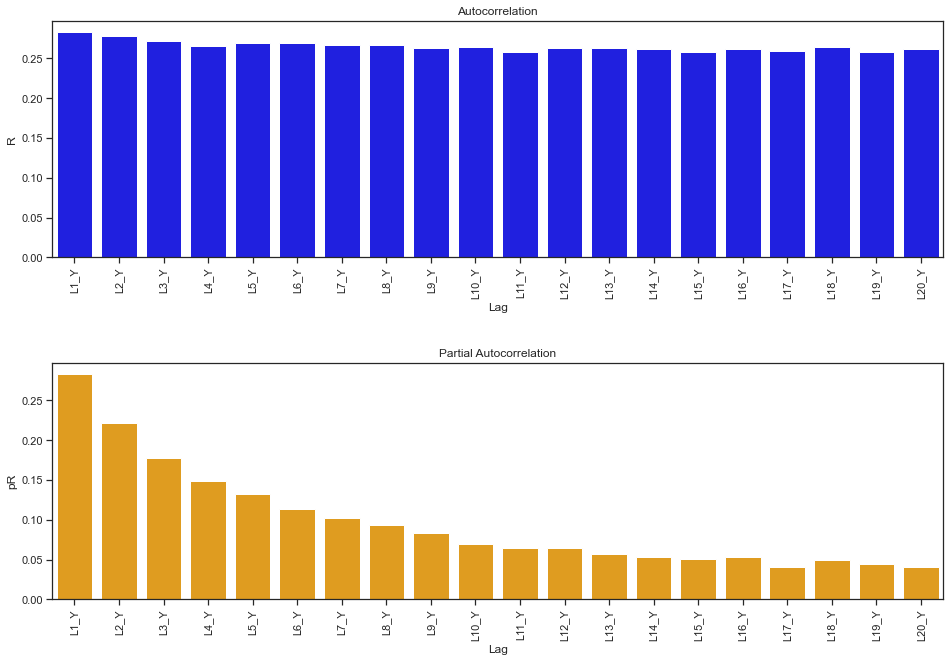

In [15]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

x_ticks = []
corrs = []
p_corrs = []
for i in range(1, 21):
    x = 'L{}_{}'.format(str(i), y)

    boxscores = feature_creation.lag(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=clean_y, new_col_name=x, n_shift=i
    )
    
    corr = boxscores[clean_y].corr(boxscores[x])
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=x_ticks)
    
    corrs.append(corr)
    p_corrs.append(p_corr['r'][0])
    x_ticks.append(x)
    
corr_df = pd.DataFrame({'R': corrs, 'pR': p_corrs, 'Lag': x_ticks})

sns.barplot(x='Lag', y='R', data=corr_df, color='blue', ax=ax[0])
ax[0].set_xticklabels(ax[0].get_xticklabels(),rotation=90)
ax[0].title.set_text('Autocorrelation')

sns.barplot(x='Lag', y='pR', data=corr_df, color='orange', ax=ax[1])
ax[1].set_xticklabels(ax[1].get_xticklabels(),rotation=90)
ax[1].title.set_text('Partial Autocorrelation')

fig.tight_layout(pad=3.0)
plt.show()
plt.close()

While the Autocorrelaton of each between $Y$ and each $Y_{i}$ is similar, the Partial Autocorrelations exponentially decrease. This tells us that each $Y_{i}$ tells us less new information than the preceding lag does. This is a reason for us to add the first lag of Y to our list of regressors. It also makes the case that an exponentially weighted mean of previous $Y$ lags may be more predictive of $Y$ than a normal mean.

In [16]:
regressors.append('L1_Y')
    
boxscores = feature_creation.expanding_ewm(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name='EWM_Y', alpha=0.90
)
regressors.append('EWM_Y')

Next, I will calculate the partial correlation between $Y$ and previous moveing averages of $Y$, using a covariate of the AVG_$Y$. The peak of this graph will tell us which MA provides the most new information on top of AVG_$Y$.

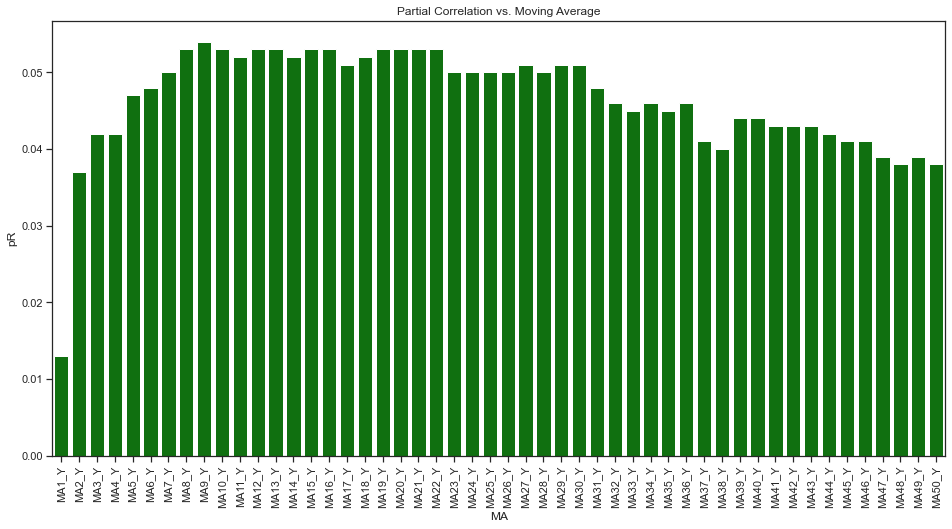

In [18]:
x_ticks = []
p_corrs = []
for i in range(1, 51):
    x = 'MA{}_{}'.format(str(i), y)

    boxscores = feature_creation.rolling_weighted_mean(
        df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name=y, new_col_name=x,
        weight_col_name='SECONDSPLAYED', n_rolling=i, min_periods=math.ceil(i/2)
    )
    
    p_corr = pg.partial_corr(data=boxscores, x=x, y=clean_y, covar=['AVG_Y'])
    
    x_ticks.append(x)
    p_corrs.append(p_corr['r'][0])
    
corr_df = pd.DataFrame({'pR': p_corrs, 'MA': x_ticks})
ax = sns.barplot(x='MA', y='pR', data=corr_df, color='green')
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
ax.title.set_text('Partial Correlation vs. Moving Average')
plt.show()
plt.close()

I will use MA2_$Y$ and MA8_$Y$. Lower moveing averages are more convinient to use than higher ones because we need less data points to calculate them.

In [19]:
regressors.append('MA2_Y')
regressors.append('MA8_Y')

Now I will determine if the dependant variable, $Y$, depends on various categorical variables in our data set.

First I will visualize the difference of the distributions and means of $Y$ when a player is playing at Home or Away.

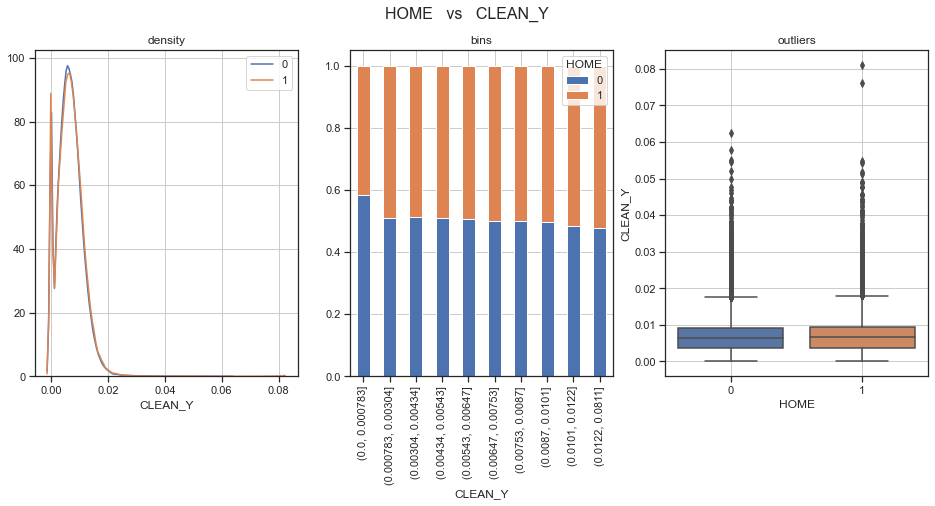

In [20]:
boxscores['HOME'] = 0
boxscores.loc[boxscores['TEAM'] == boxscores['HTM'], 'HOME'] = 1
helpers.visualize_categorical_x_vs_y(boxscores, 'HOME', clean_y)

There does not seem to be a relationship between the location a player plays at and his $PPS$.

Next I will determine if a player's $PPS$ depends on his status as a Starter.

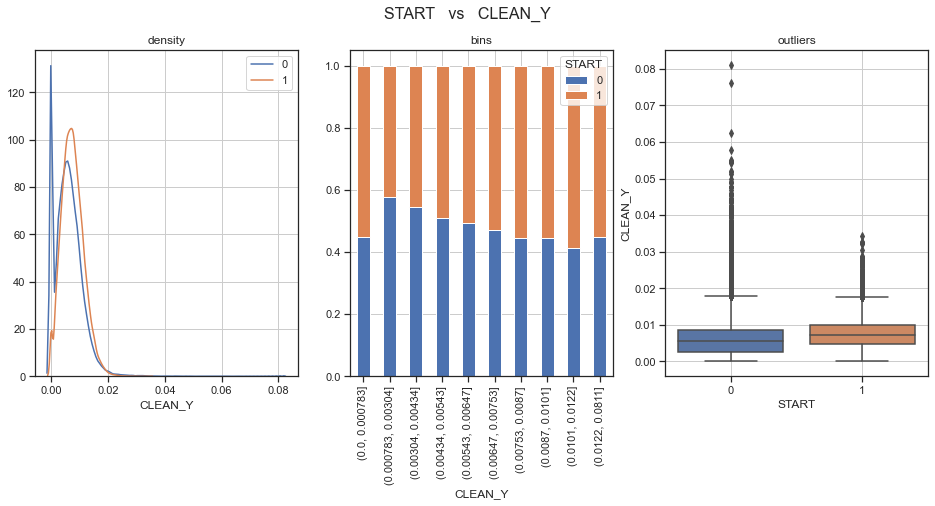

In [21]:
helpers.visualize_categorical_x_vs_y(boxscores, 'START', clean_y)

At a glance, it seems like there may be a slight relationship between starting status and $PPS$.

To confirm this hypothesis, I will investigate the percentage of (season, player) groups in the dataset exhibit a statistically significant difference between their mean $PPS$ when they start and are benched. To test significance, I will use a one-way ANOVA test.

In [22]:
num_valid_player_seasons = 0
significant_player_seasons = []
a = 0.01
for player_season, temp in boxscores.groupby(['SEASON', 'PLAYERID']):
    anova = pg.anova(dv=y, between='START', data=temp, detailed=False)
    p = anova['p-unc'].iloc[0]
    if p != '-':
        num_valid_player_seasons += 1
        if float(p) < a:
            significant_player_seasons.append(player_season)

print('Number of significant (season, player) combinations:', len(significant_player_seasons))
print('Percentage of significant (season, player) combinations:', len(significant_player_seasons)/num_valid_player_seasons)

Number of significant (season, player) combinations: 35
Percentage of significant (season, player) combinations: 0.01971830985915493


The percentage of (season, player) combinations that exibit a significant difference is 1.97%, almost twice our alpha of 1%. This is enough to add a categorical variable that identifies if a player is starting, 'START', to the list of regressors. I will also add the season average $PPS$ of a player in the role he is playing to our list of regressors. I will call this variable: $AVG\_Y\_R$.

In [23]:
regressors.append('START')
categorical_regressors.append('START')

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID', 'START'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_R'
)
regressors.append('AVG_Y_R')

Next, I will determine if the number of days a player rests is indicative of his $PPS$.

In [24]:
boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='DATE', new_col_name='LAST_DATE'
)
boxscores['LAST_DATE'] = boxscores['LAST_DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)
boxscores['DATE'] = boxscores['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores['REST'] = boxscores[['DATE', 'LAST_DATE']].apply(
    lambda x: max(min((x[0] - x[1]).days, 5), 1) if not (isinstance(x[0], str) or isinstance(x[1], str)) else np.nan,
    axis=1
)

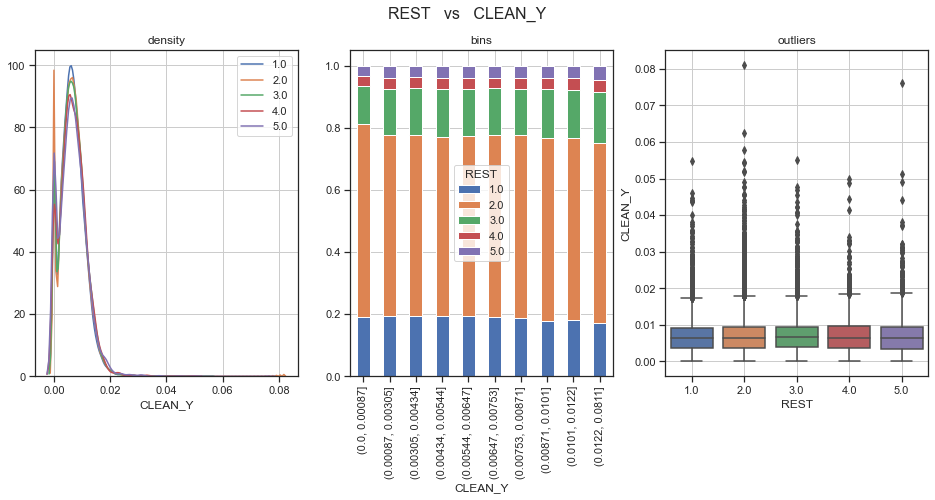

In [25]:
helpers.visualize_categorical_x_vs_y(boxscores, 'REST', clean_y)

No significant relationship.

What if a player's shooting volume has been high, but he has been shooting poorly? His recent $PPS$ performances may be low/average, but if the volume continues and his slump ends, his $PPS$ would increase. I will create metrics to measure a player's historical Potential Points Per Second ($PPPS$).

In [26]:
# attempt formula from the True Shooting Percentage statistic
boxscores['PP'] = 3*boxscores['FG3A'] + 2*(boxscores['FGA']-boxscores['FG3A']) + 1*boxscores['FTA']
boxscores['PPPS'] = boxscores['PP']/boxscores['SECONDSPLAYED']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PPPS', new_col_name='AVG_PPPS', weight_col_name='SECONDSPLAYED'
)

boxscores = feature_creation.lag(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PPPS', new_col_name='L1_PPPS', n_shift=1
)

boxscores = feature_creation.rolling_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PPPS', new_col_name='MA3_PPPS',
    weight_col_name='SECONDSPLAYED', n_rolling=3, min_periods=2
)

regressors.append('AVG_PPPS')
regressors.append('L1_PPPS')
regressors.append('MA3_PPPS')

I will also create a metric to measure what proportion of the potential points a player captured, Point Capture Rate ($PCR$)

In [27]:
boxscores['PCR'] = boxscores['PTS']/boxscores['PP']

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PCR', new_col_name='AVG_PCR',
    weight_col_name='PP'
)

boxscores = feature_creation.rolling_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PCR', new_col_name='MA3_PCR',
    weight_col_name='PP', n_rolling=3
)

regressors.append('AVG_PCR')
regressors.append('MA3_PCR')

### Defense
Next, I will create features that measure the defense of the opposing team.

First, I will calculate the defense of each team on a game-to-game basis. I will define defense as:

$$TEAM\_Y\_DIFF\_ALLOWED =  TEAM\_Y\_ALLOWED - TEAM\_Y\_AVG$$

where $TEAM\_Y\_ALLOWED$ is the $PPS$ allowed to the opposing team and $TEAM\_Y\_AVG$ is the $PPS$ of that team throughout the season coming into the game.

In [28]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='PTS', new_col_name='AVG_PTS'
)
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='AVG_SP'
)

temp = boxscores.dropna(subset=['PTS', 'SECONDSPLAYED', 'AVG_PTS', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED': x['PTS'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG': x['AVG_PTS'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED'] - grouped_defensive_boxscores['TEAM_Y_AVG']

Next, I will visualize the defense of each team for each season in the dataset. I will also run a one-way ANOVA test to determine if the mean $TEAM\_Y\_DIFF\_ALLOWED$ differs among the teams in each season.

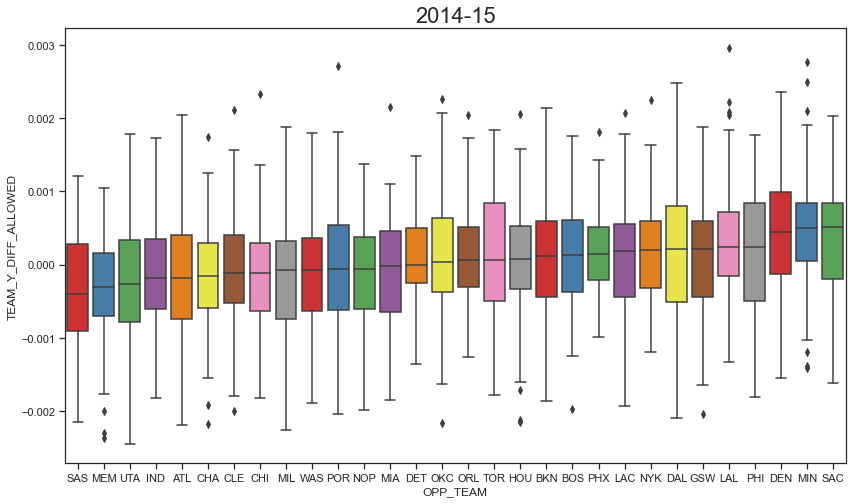

Team defenses are statistically siginficantly different


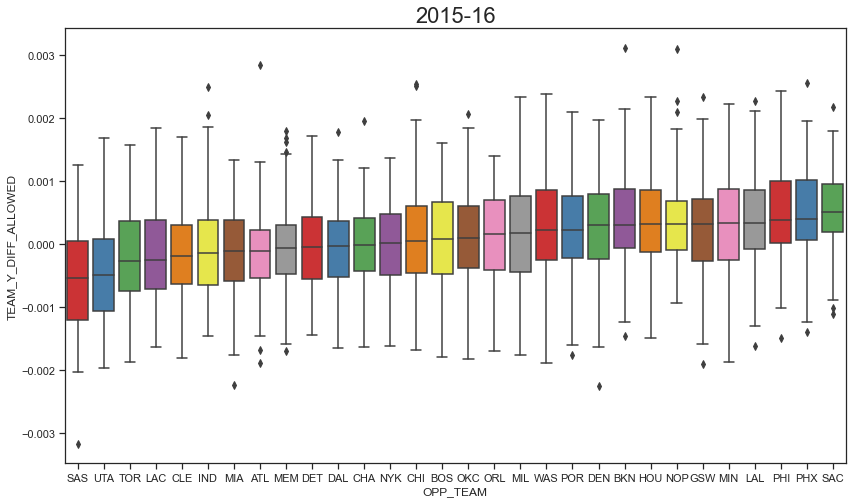

Team defenses are statistically siginficantly different


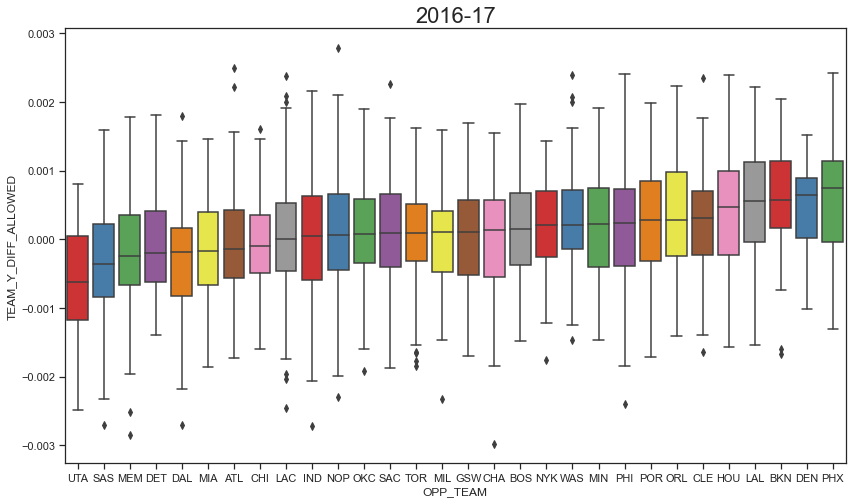

Team defenses are statistically siginficantly different


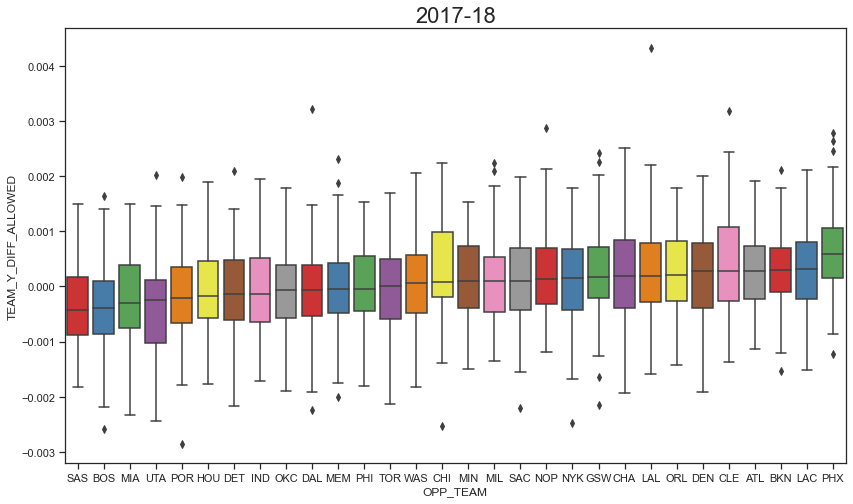

Team defenses are statistically siginficantly different


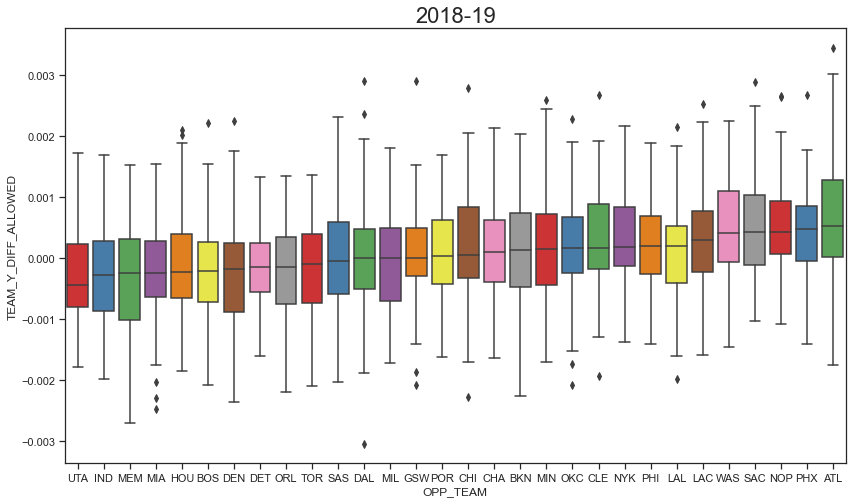

Team defenses are statistically siginficantly different


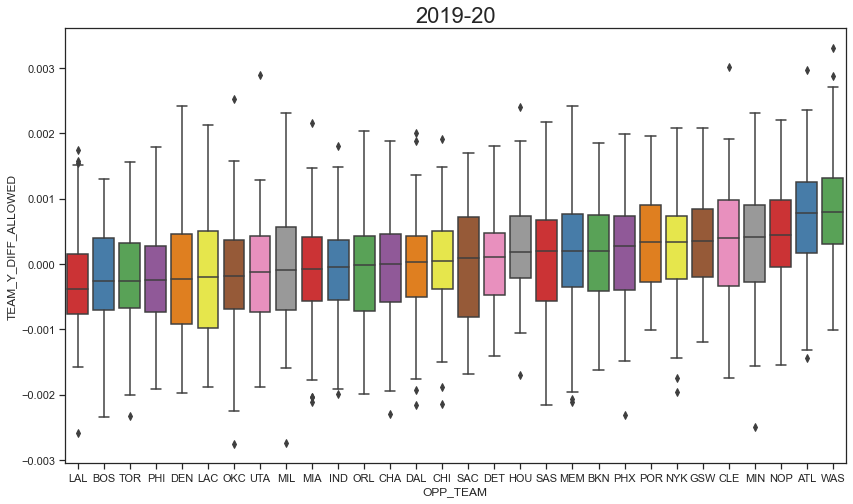

Team defenses are statistically siginficantly different


In [29]:
a = 0.01
for season, temp in grouped_defensive_boxscores.groupby(['SEASON']):
    plt.figure(figsize=(14, 8))
    plt.title(season,fontsize=22)
    opp_team_def = [
        (opp_team, temp2['TEAM_Y_DIFF_ALLOWED'].median()) for opp_team, temp2 in temp.groupby('OPP_TEAM')
    ]
    opp_team_def.sort(key = lambda x: x[1])
    opp_teams = [i[0] for i in opp_team_def]
    sns.boxplot(x="OPP_TEAM", y="TEAM_Y_DIFF_ALLOWED", data=temp, palette="Set1", order=opp_teams)
    
    plt.show()
    plt.close()
    
    anova = pg.anova(dv='TEAM_Y_DIFF_ALLOWED', between='OPP_TEAM', data=temp, detailed=True)
    p = anova['p-unc'].iloc[0]
    if p < a:
        print('Team defenses are statistically siginficantly different')
    else:
        print('Team defenses are not statistically siginficantly different')

The average defenses of each team seem to be significantly different from each other each season.

Now, I will create calculate the average defense of the opposing team across all previous games in a season, $AVG\_TEAM\_Y\_DIFF\_ALLOWED$. Then, I will visualize it's correlation with the dependant variable.

In [30]:
grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM'], col_name='TEAM_Y_DIFF_ALLOWED', new_col_name='AVG_TEAM_Y_DIFF_ALLOWED',
    order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM'], how='left')

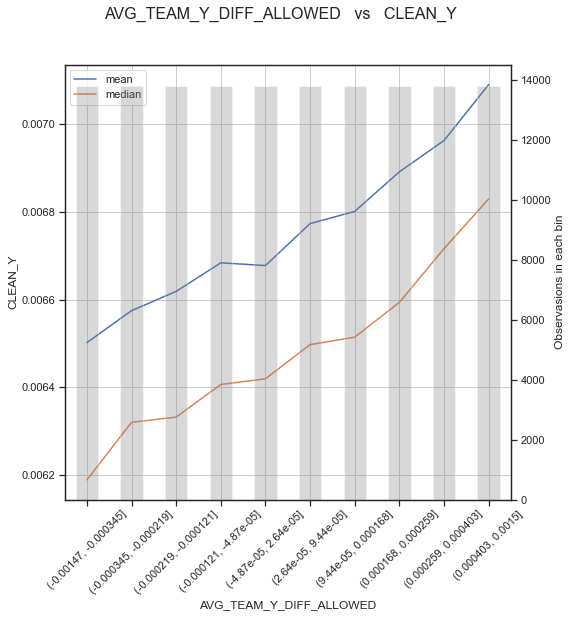

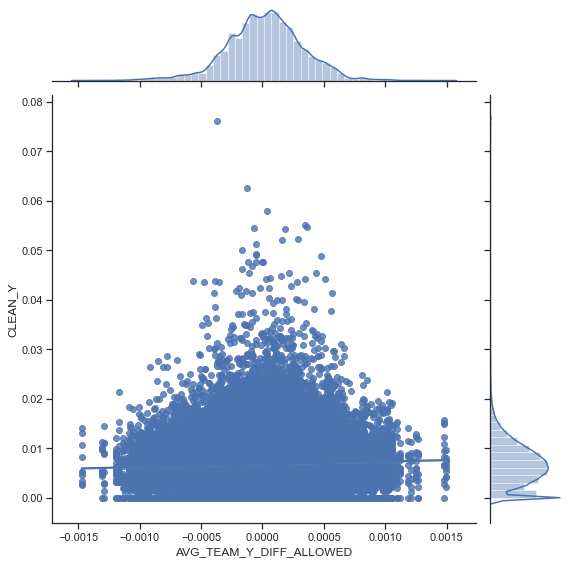

In [31]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED', clean_y, figsize=(8, 8))

In [32]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED')

The metrics above track the opposing team's defense on all players. However, an opposing team's defense may differ among starts and bench players, as each set will have a mostly different group of opposing players.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_R$ to quantify a team's defense on opposing players by role (start/bench).

In [33]:
temp = boxscores.dropna(subset=['PTS', 'SECONDSPLAYED', 'AVG_PTS', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'START', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_R': x['PTS'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_R': x['AVG_PTS'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_R'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_R'] - grouped_defensive_boxscores['TEAM_Y_AVG_R']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'START'], col_name='TEAM_Y_DIFF_ALLOWED_R',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_R', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'START'], how='left')

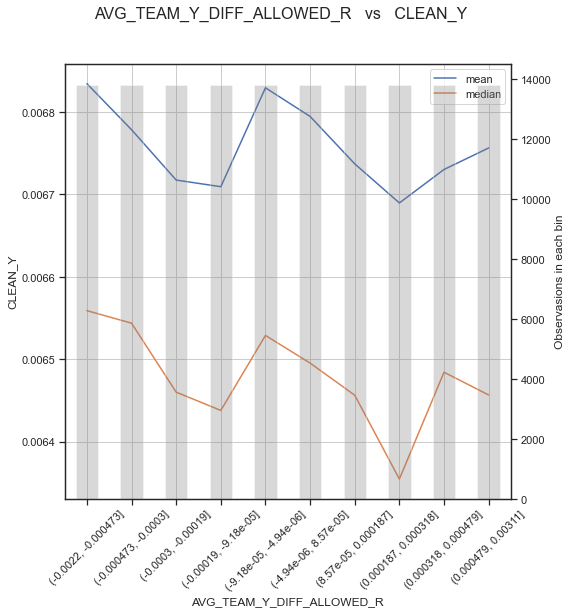

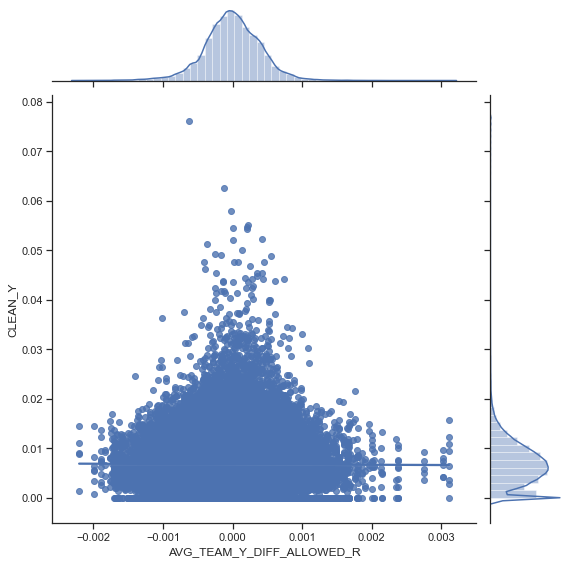

In [34]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_R', clean_y, figsize=(8, 8))

This variable does not seem at all indicative of the dependant variable. I will not include this in the list of regressors.

Opposing teams may also defend different positions differently.

I will use the variable $TEAM\_Y\_DIFF\_ALLOWED\_P$ to quantify a team's defense on opposing players by role (guard/forward/center).

In [35]:
boxscores['NORM_POS'] = boxscores['POSITION'].apply(lambda x: x if '-' not in x else x.split('-')[0])

temp = boxscores.dropna(subset=['PTS', 'SECONDSPLAYED', 'AVG_PTS', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'NORM_POS', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_P': x['PTS'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_P': x['AVG_PTS'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_P'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_P'] - grouped_defensive_boxscores['TEAM_Y_AVG_P']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'NORM_POS'], col_name='TEAM_Y_DIFF_ALLOWED_P',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_P', order_idx_name='DATE', min_periods=5
)

boxscores = boxscores.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'NORM_POS'], how='left')

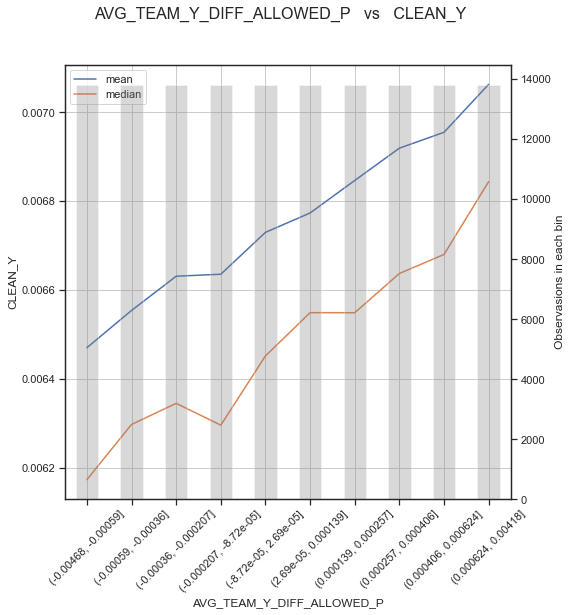

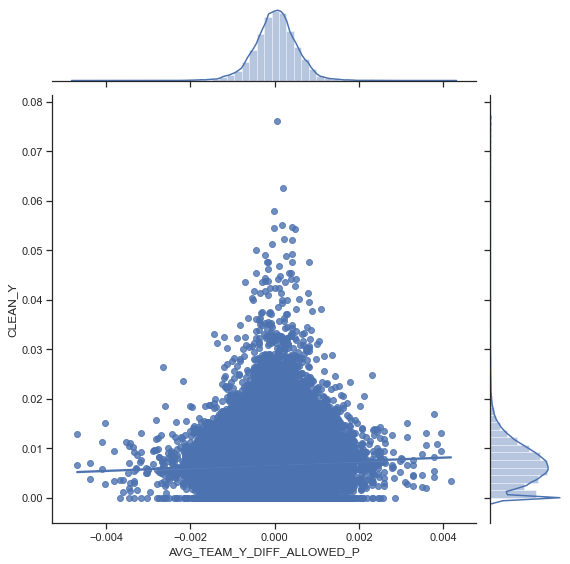

In [36]:
helpers.visualize_numeric_x_vs_y(boxscores, 'AVG_TEAM_Y_DIFF_ALLOWED_P', clean_y, figsize=(8, 8))

This variable seems to be correlated with the dependant variable. I will add the defensive metric I calulcated to the list of regressors.

In [37]:
regressors.append('AVG_TEAM_Y_DIFF_ALLOWED_P')

What if we can do better by grouping players by their position. LeBron James and Paul Millsap are both classified as Forwards in our dataset, but they have much different playing styles.

To answer this question, I will first cluster NBA players by stats that better define the type of offensive player they are. Then, I will calculate the $TEAM\_Y\_DIFF\_ALLOWED$ statistic for each cluster of player.

In [38]:
create_data = CreateData()

stat_cols = ['FGA', 'FGM', 'FG3A', 'FG3M', 'FTA', 'FTM', 'PCT_AST_2PM', 'PCT_AST_3PM', \
             'PTS_2ND_CHANCE', 'PTS_FB', 'PTS_PAINT', 'PTS', 'AST', 'AST_PCT', 'DREB', 'OREB', 'OREB_PCT', 'STL',
             'HEIGHT', 'WEIGHT', 'SECONDSPLAYED']
                
season_player_stats = create_data.create_group_avergage_stats(df=boxscores, group_cols=['SEASON', 'NAME'], stat_cols=stat_cols)
season_player_stats = season_player_stats.loc[season_player_stats['FGA'] > 3]

season_player_stats['FGAPS'] = season_player_stats['FGA']/season_player_stats['SECONDSPLAYED']
season_player_stats['FTAPFGA'] = season_player_stats['FTA']/season_player_stats['FGA']

season_player_stats['FG3%'] = season_player_stats['FG3M']/season_player_stats['FG3A']
season_player_stats['PCT_FGA_FG3'] = season_player_stats['FG3A']/season_player_stats['FGA']

season_player_stats['FG2M'] = season_player_stats['FGM'] - season_player_stats['FG3M']
season_player_stats['AST_FGM'] = (season_player_stats['PCT_AST_2PM']*season_player_stats['FG2M']) + (season_player_stats['PCT_AST_3PM']*season_player_stats['FG3M'])
season_player_stats['PCT_AST_FGM'] = season_player_stats['AST_FGM']/season_player_stats['FGM']
season_player_stats['PCT_PTS_2ND_CHANCE'] = season_player_stats['PTS_2ND_CHANCE']/season_player_stats['PTS']
season_player_stats['PCT_PTS_FB'] = season_player_stats['PTS_FB']/season_player_stats['PTS']
season_player_stats['PCT_PTS_PAINT'] = season_player_stats['PTS_PAINT']/season_player_stats['PTS']

season_player_stats['ASTPS'] = season_player_stats['AST']/season_player_stats['SECONDSPLAYED']
season_player_stats['REB'] = season_player_stats['OREB'] + season_player_stats['DREB']
season_player_stats['REBPS'] = season_player_stats['REB']/season_player_stats['SECONDSPLAYED']
season_player_stats['OREBPS'] = season_player_stats['OREB']/season_player_stats['SECONDSPLAYED']
season_player_stats['STLPS'] = season_player_stats['STL']/season_player_stats['SECONDSPLAYED']

cluster_cols = ['PCT_AST_FGM', 'FG3%', 'PCT_FGA_FG3', 'PCT_PTS_FB', 'OREB_PCT', 'AST_PCT', 'HEIGHT', 'WEIGHT']

season_player_stats[cluster_cols] = season_player_stats[cluster_cols].replace([np.nan, np.inf], 0)

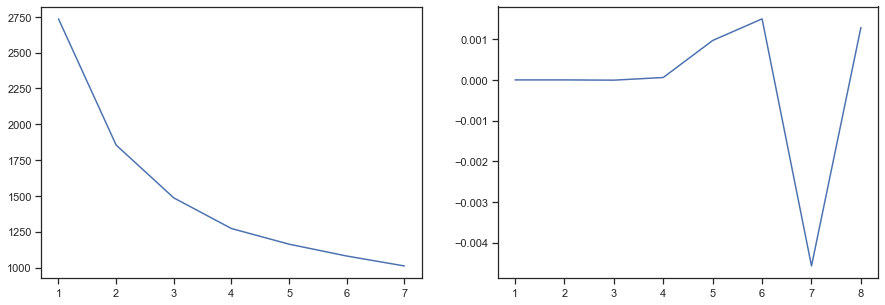

In [39]:
temp = season_player_stats.loc['2019-20']
evaluate = Evaluate(df=temp, cluster_cols=cluster_cols)

# optimal number of clusters
optimal_k = evaluate.optimal_kmeans_n_clusters(max_n_clusters=8)

Below is a visualization of the clusters we created for the 2018-19 season.

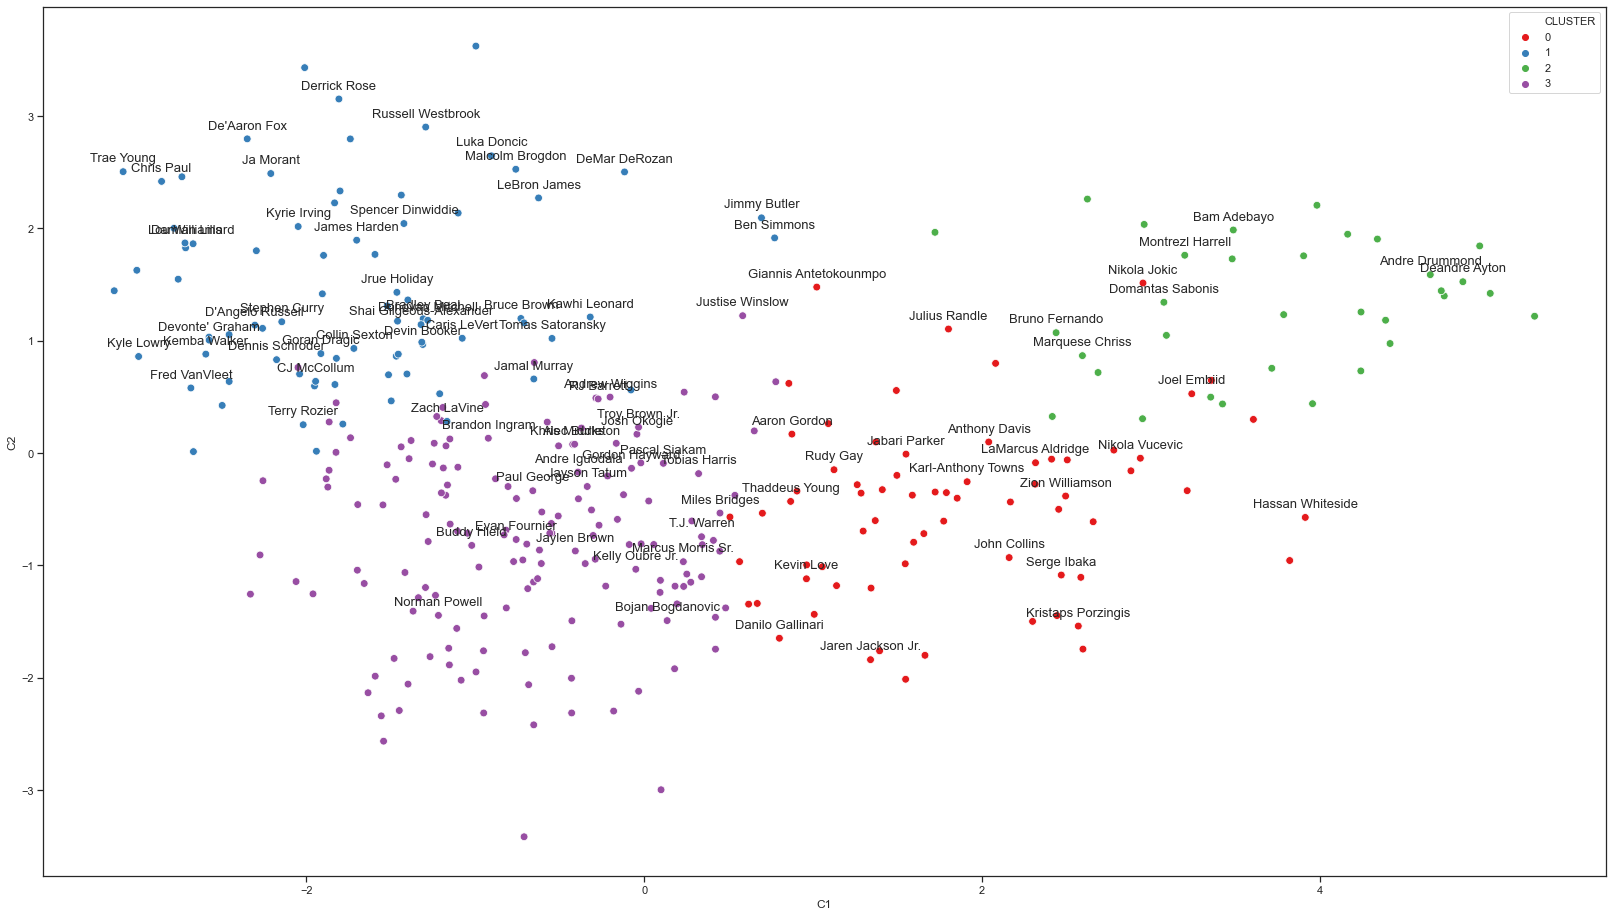

In [40]:
temp = season_player_stats.loc['2019-20']
evaluate.visualize_clusters(df=temp, cluster_cols=cluster_cols, n_clusters=4)

These clusters seem to group playing styles together well.

Now, I will merge these clusters to my original dataset, cluster defensive statistic, and visualize its correlation with $Y$.

In [41]:
season_list = boxscores['SEASON'].unique()
season_list.sort()

clusters = pd.DataFrame()
for i in range(len(season_list)-1):
    current_season = season_list[i]
    next_season = season_list[i+1]

    temp = season_player_stats.loc[current_season]
    cluster = Cluster(df=temp, cluster_cols=cluster_cols)
    season_clusters = cluster.create_kmeans_clusters(n_clusters=4)
    season_clusters['SEASON'] = next_season

    clusters = clusters.append(season_clusters.reset_index())

temp = boxscores.merge(clusters, on=['SEASON', 'NAME'], how='left').set_index('GAMEID').sort_index()
temp = temp.dropna(subset=['CLUSTER'])

In [42]:
temp = temp.dropna(subset=['PTS', 'SECONDSPLAYED', 'AVG_PTS', 'AVG_SP'])
grouped_defensive_boxscores = temp.groupby(['SEASON', 'DATE', 'CLUSTER', 'OPP_TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_Y_ALLOWED_C': x['PTS'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_Y_AVG_C': x['AVG_PTS'].sum()/x['AVG_SP'].sum()
    })
).reset_index()

grouped_defensive_boxscores['TEAM_Y_DIFF_ALLOWED_C'] = grouped_defensive_boxscores['TEAM_Y_ALLOWED_C'] - grouped_defensive_boxscores['TEAM_Y_AVG_C']

grouped_defensive_boxscores = feature_creation.expanding_mean(
    df=grouped_defensive_boxscores, group_col_names=['SEASON', 'OPP_TEAM', 'CLUSTER'], col_name='TEAM_Y_DIFF_ALLOWED_C',
    new_col_name='AVG_TEAM_Y_DIFF_ALLOWED_C', order_idx_name='DATE', min_periods=5
)
temp = temp.merge(grouped_defensive_boxscores, on=['SEASON', 'DATE', 'OPP_TEAM', 'CLUSTER'], how='left')

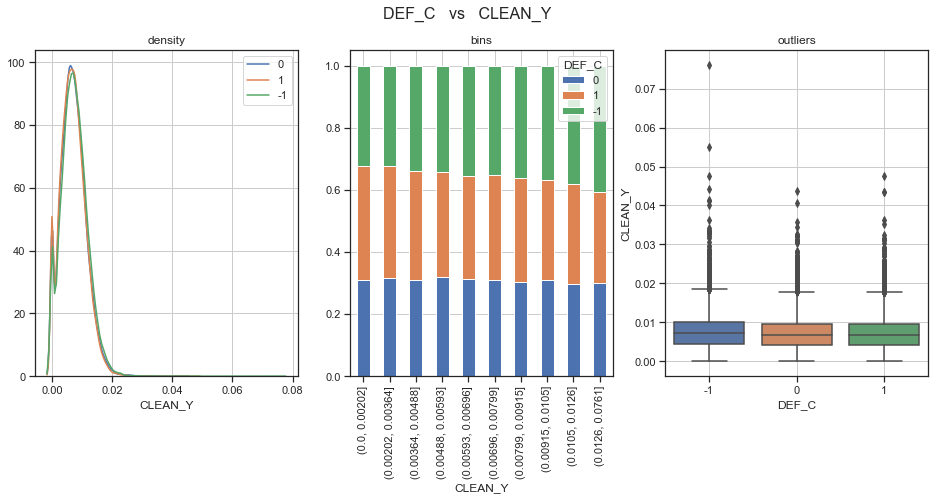

In [43]:
temp['DEF_C'] = 0
temp.loc[temp['AVG_TEAM_Y_DIFF_ALLOWED_C'] > 0.0002, 'DEF_C'] = -1
temp.loc[temp['AVG_TEAM_Y_DIFF_ALLOWED_C'] < -0.0002, 'DEF_C'] = 1
helpers.visualize_categorical_x_vs_y(temp, 'DEF_C', clean_y)

This variable does not seem more indicative of the dependant variable than $AVG\_TEAM\_PPS\_DIFF\_ALLOWED\_P$. I will not include this in the list of regressors.

I will also include the vegas implied game point total as a feature.

In [44]:
odds = query_data.query_odds_data()
odds['TOTAL'] = odds['TOTAL'].replace(['PK', '-'], np.nan)
full_game_odds = odds.loc[odds['PERIOD'] == 'Full Game']

In [45]:
full_game_odds['DATE'] = full_game_odds['DATE'].apply(
    lambda x: datetime.strptime(x, '%Y-%m-%d') if isinstance(x, str) else ''
)

boxscores = boxscores.merge(full_game_odds, on=['DATE', 'TEAM'], how='left')

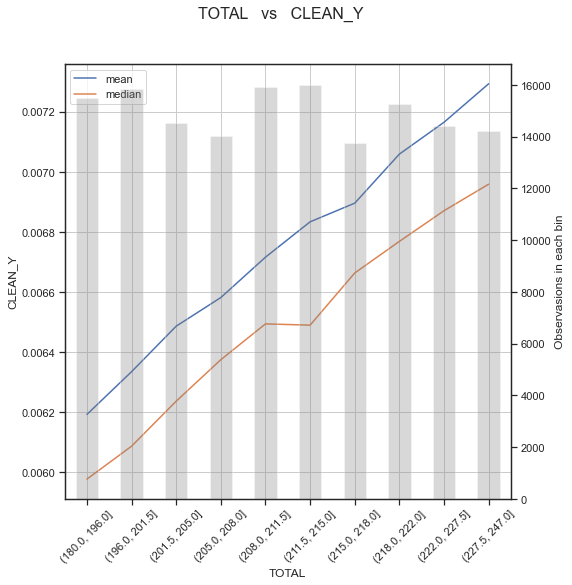

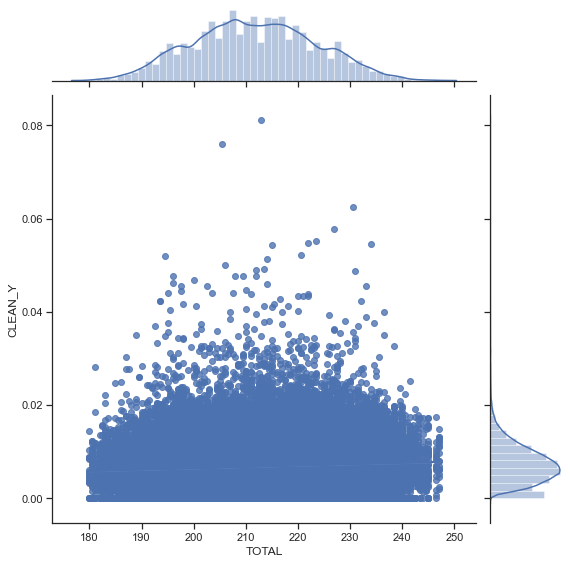

In [46]:
helpers.visualize_numeric_x_vs_y(boxscores, 'TOTAL', clean_y, figsize=(8, 8))

In [47]:
regressors.append('TOTAL')

### Injuries
Finally, I will create features that quantify how injured the lineup is from a production standpoint.

The first variable I will create to capture how injured the lineup is will be called $TEAM\_ACTIVE\_AVG\_FGAPS\_DIFF$. This will capture the difference between the FGAPS (FGA Per Second) of the players of a team active in a game, and the average FGAPS of that team. For example, if the sum of the average seconds played of the active players on a team was 14400, and the sum of the average FGA of the active players on the team was 80, the $TEAM\_ACTIVE\_AVG\_FGAPS$ would be $80/14400 = 0.00556$. If the next game, LeBron James was out (who is on the team and averaged 2000 seconds played and 20 FGA) the $TEAM\_ACTIVE\_AVG\_FGAPS$ would be $(80-20)/(14400-2000) = 0.00484$. In this case $TEAM\_ACTIVE\_AVG\_FGAPS\_DIFF$ would be $0.00565-0.00694 = -0.000721$. This lower number would hopefully be more indicative of a higher $PPS$ for the rest of the team.

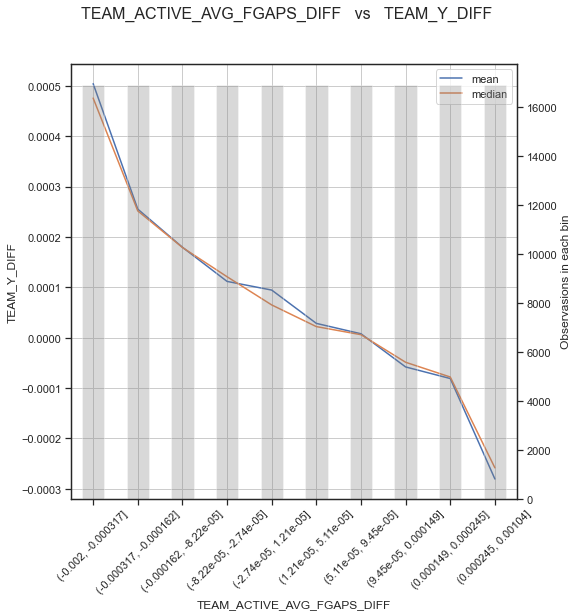

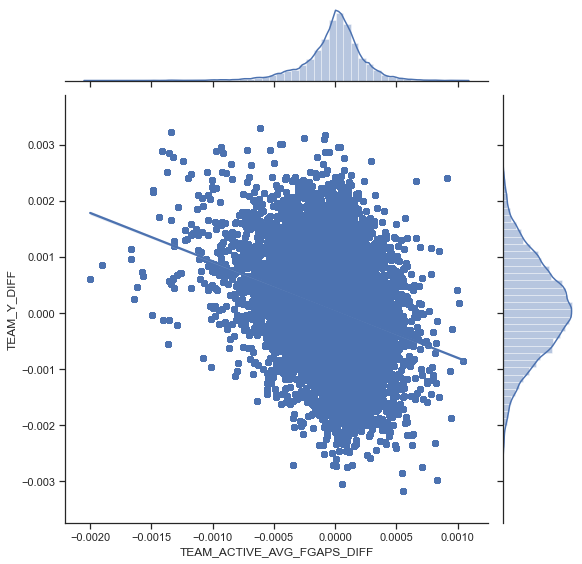

In [48]:
boxscores = feature_creation.expanding_mean(
    df=boxscores, group_col_names=['SEASON', 'TEAM', 'PLAYERID'], col_name='FGA', new_col_name='AVG_FGA'
)

temp = boxscores.dropna(subset=['AVG_SP', 'AVG_FGA', 'FGA', 'SECONDSPLAYED'])
temp = temp.groupby(['SEASON', 'GAMEID', 'TEAM']).apply(
    lambda x: pd.Series({
        'TEAM_ACTIVE_AVG_FGAPS': x['AVG_FGA'].sum()/x['AVG_SP'].sum(),
        'TEAM_FGAPS': x['FGA'].sum()/x['SECONDSPLAYED'].sum(),
        'TEAM_ACTIVE_AVG_Y': x['AVG_PTS'].sum()/x['AVG_SP'].sum(),
        'TEAM_Y': x['PTS'].sum()/x['SECONDSPLAYED'].sum()
    })
)
temp = feature_creation.expanding_mean(
    df=temp, group_col_names=['SEASON', 'TEAM'], col_name='TEAM_FGAPS', new_col_name='AVG_TEAM_FGAPS'
)
temp['TEAM_ACTIVE_AVG_FGAPS_DIFF'] = temp['TEAM_ACTIVE_AVG_FGAPS'] - temp['AVG_TEAM_FGAPS']
temp['TEAM_Y_DIFF'] = temp['TEAM_Y'] - temp['TEAM_ACTIVE_AVG_Y']

boxscores = boxscores.merge(temp, on=['GAMEID', 'TEAM'], how='left')
helpers.visualize_numeric_x_vs_y(boxscores, 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'TEAM_Y_DIFF', figsize=(8, 8))

It seems as though a lower $TEAM\_ACTIVE\_AVG\_FGAPS\_DIFF$ is indicative of a higher $TEAM\_PPS$ than the active players average. I will add this to my list of regressors.

In [49]:
regressors.append('TEAM_ACTIVE_AVG_FGAPS_DIFF')

Not all players absorb lost usage equally. To account for this, I will create features that track the $AVG\_PPS$ and $AVG\_APS$ of players when the starting lineup was the same. I will also create features that track the $AVG\_PPS$ and $AVG\_APS$ of players when the active star players on the team were the same (I will define 'star player' in this context as a player who averages over 20 Points Per Game).

In [50]:
boxscores['START_LINEUP'] = np.nan
boxscores['STARS'] = np.nan
boxscores = boxscores.set_index(['GAMEID', 'TEAM'])
for (game_id, team), temp in boxscores.groupby(['GAMEID', 'TEAM']):
    start_lineup = list(temp.loc[temp['START'] == 1, 'PLAYERID'].values)
    start_lineup.sort()
    start_lineup = '_'.join(start_lineup)
    boxscores.loc[(game_id, team), 'START_LINEUP'] = start_lineup
    
    stars = list(temp.loc[temp['AVG_PTS'] > 20, 'PLAYERID'].values)
    stars.sort()
    stars = '_'.join(stars)
    boxscores.loc[(game_id, team), 'STARS'] = stars
boxscores = boxscores.reset_index()

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name=y, weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_Y_STARS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'START_LINEUP', 'PLAYERID'], col_name='PPPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_PPPS_STARTERS'
)

boxscores = feature_creation.expanding_weighted_mean(
    df=boxscores, group_col_names=['SEASON', 'STARS', 'PLAYERID'], col_name='PPPS', weight_col_name='SECONDSPLAYED',
    new_col_name='AVG_PPPS_STARS'
)

To determine if these features provide new information, I will calcuate the partial correlation between each of them and the dependant variable, using $AVG\_Y$ as the covariate.

In [51]:
print('Partial correlation between AVG_PPS_STARTERS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARTERS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_PPS_STARS and Y with covariate AVG_Y:')
pc = pg.partial_corr(data=boxscores, x='AVG_Y_STARS', y=clean_y, covar=['AVG_Y'])
display(pc)

print('Partial correlation between AVG_APS_STARTERS and APS with covariate AVG_APS:')
pc = pg.partial_corr(data=boxscores, x='AVG_PPPS_STARTERS', y='PPPS', covar=['AVG_PPPS'])
display(pc)

print('Partial correlation between AVG_APS_STARS and APS with covariate AVG_APS:')
pc = pg.partial_corr(data=boxscores, x='AVG_PPPS_STARS', y='PPPS', covar=['AVG_PPPS'])
display(pc)

Partial correlation between AVG_PPS_STARTERS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,110230,0.019,"[0.01, 0.03]",0.0,0.0,1.505994e-10,3.051e+06,1.0


Partial correlation between AVG_PPS_STARS and Y with covariate AVG_Y:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,140249,0.018,"[0.01, 0.02]",0.0,0.0,6.408472e-12,5.942e+07,1.0


Partial correlation between AVG_APS_STARTERS and APS with covariate AVG_APS:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,111014,0.02,"[0.01, 0.03]",0.0,0.0,9.754427e-12,4.425e+07,1.0


Partial correlation between AVG_APS_STARS and APS with covariate AVG_APS:


,n,r,CI95%,r2,adj_r2,p-val,BF10,power
pearson,141354,0.018,"[0.01, 0.02]",0.0,0.0,1.785687e-11,2.169e+07,1.0


These features show a significant partial correlation with the dependent variable. I will add them to the list of regressors.

In [52]:
regressors.append('AVG_Y_STARTERS')
regressors.append('AVG_Y_STARS')
regressors.append('AVG_PPPS_STARTERS')
regressors.append('AVG_PPPS_STARS')

### Weights
Lastly, I will add a column to weight each $Y$ value. I do not care about each occurance of the dependant variable equally; the $PPS$ of a player who scores 1 point in 60 seconds should not be weighted the same as the $PPS$ of a plyer who scores 30 points in 1800 seconds.

The weight I will use will be a product of functions of the amount of seconds played in a game and the sum of seconds played by a player throughout that season:

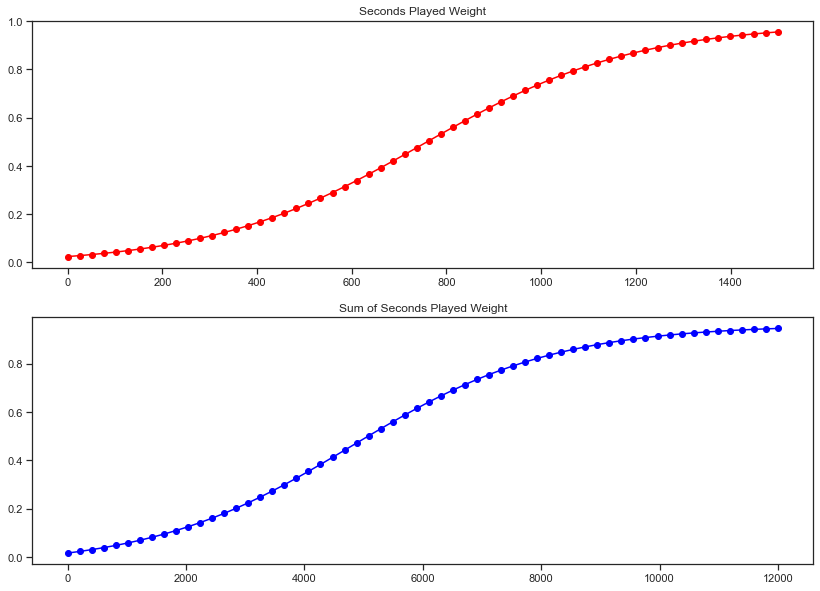

In [53]:
fig, ax = plt.subplots(nrows=2, ncols=1, sharex=False, sharey=False, figsize=(14, 10))

sp_weight_func = lambda x: 1/(1 + np.exp((-0.80*x + 600)/180)) - 0.01
sp_in_array = np.linspace(0, 60*25, 60)
sp_out_array = sp_weight_func(sp_in_array) 

tsp_weight_func = lambda x: 1/(1 + np.exp((-0.175*x + 840)/300)) - 0.04
tsp_in_array = np.linspace(0, 60*20*10, 60)
tsp_out_array = tsp_weight_func(tsp_in_array)

ax[0].title.set_text("Seconds Played Weight") 
ax[0].plot(sp_in_array, sp_out_array, color ='red', marker="o")

ax[1].title.set_text("Sum of Seconds Played Weight") 
ax[1].plot(tsp_in_array, tsp_out_array, color ='blue', marker="o") 
plt.show() 

In [54]:
boxscores = feature_creation.expanding_sum(
    df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='SECONDSPLAYED', new_col_name='SUM_SP'
)

w = 'WEIGHT'
boxscores[w] = boxscores['SECONDSPLAYED'].apply(sp_weight_func) * boxscores['SUM_SP'].apply(tsp_weight_func)

Some features we created to track historical performances mean less if the player has played less games/ minutes. To tell the non-linear models how much the player has played, I will create 2 regressors: number of games played ($COUNT\_GP$) and average seconds played ($AVG\_SP$)

In [55]:
boxscores['GP'] = 1
boxscores = feature_creation.expanding_sum(df=boxscores, group_col_names=['SEASON', 'PLAYERID'], col_name='GP', new_col_name='COUNT_GP')
regressors.append('COUNT_GP')

regressors.append('AVG_SP')

# Preprocessing
Now that I have created all the features I found to be indicative of our dependant variable, I will prepare the data to be suitable for a predictive model.

The first thing I will do is handle missing data.

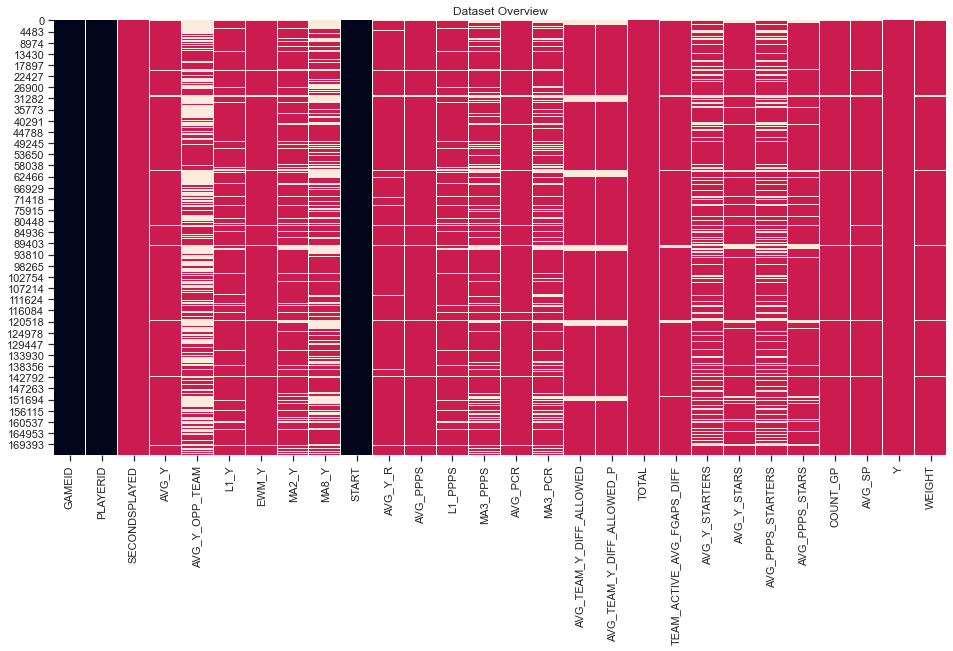

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 66.95


In [76]:
feature_matrix = boxscores[['GAMEID', 'PLAYERID', 'SECONDSPLAYED'] + regressors + [y] + [w]]

#drop games in which players played a minute or less
feature_matrix = feature_matrix.loc[feature_matrix['SECONDSPLAYED'] > 60]

helpers.visualize_dataframe(feature_matrix)

In [77]:
feature_matrix['AVG_Y_R'] = feature_matrix['AVG_Y_R'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_OPP_TEAM'] = feature_matrix['AVG_Y_OPP_TEAM'].fillna(feature_matrix['AVG_Y'])
feature_matrix['L1_Y'] = feature_matrix['L1_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['EWM_Y'] = feature_matrix['EWM_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA2_Y'] = feature_matrix['MA2_Y'].fillna(feature_matrix['AVG_Y'])
feature_matrix['MA8_Y'] = feature_matrix['MA8_Y'].fillna(feature_matrix['MA2_Y'])

feature_matrix['L1_PPPS'] = feature_matrix['L1_PPPS'].fillna(feature_matrix['AVG_PPPS'])
feature_matrix['MA3_PPPS'] = feature_matrix['MA3_PPPS'].fillna(feature_matrix['AVG_PPPS'])

feature_matrix['AVG_PCR'] = feature_matrix['AVG_PCR'].fillna(feature_matrix['AVG_PCR'].mean())
feature_matrix['MA3_PCR'] = feature_matrix['MA3_PCR'].fillna(feature_matrix['AVG_PCR'])

feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED'].fillna(0)
feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].fillna(0)

feature_matrix['TEAM_ACTIVE_AVG_FGAPS_DIFF'] = feature_matrix['TEAM_ACTIVE_AVG_FGAPS_DIFF'].fillna(0)
feature_matrix['AVG_Y_STARS'] = feature_matrix['AVG_Y_STARS'].fillna(feature_matrix['AVG_Y'])
feature_matrix['AVG_Y_STARTERS'] = feature_matrix['AVG_Y_STARTERS'].fillna(feature_matrix['AVG_Y_STARS'])

feature_matrix['AVG_PPPS_STARS'] = feature_matrix['AVG_PPPS_STARS'].fillna(feature_matrix['AVG_PPPS'])
feature_matrix['AVG_PPPS_STARTERS'] = feature_matrix['AVG_PPPS_STARTERS'].fillna(feature_matrix['AVG_PPPS_STARS'])

feature_matrix['COUNT_GP'] = feature_matrix['COUNT_GP'].fillna(0)

feature_matrix['TOTAL'] = feature_matrix['TOTAL'].fillna(200)

# we can predict Y for a player as long as AVG_Y is not nan
feature_matrix = feature_matrix.dropna(subset=['AVG_Y'])

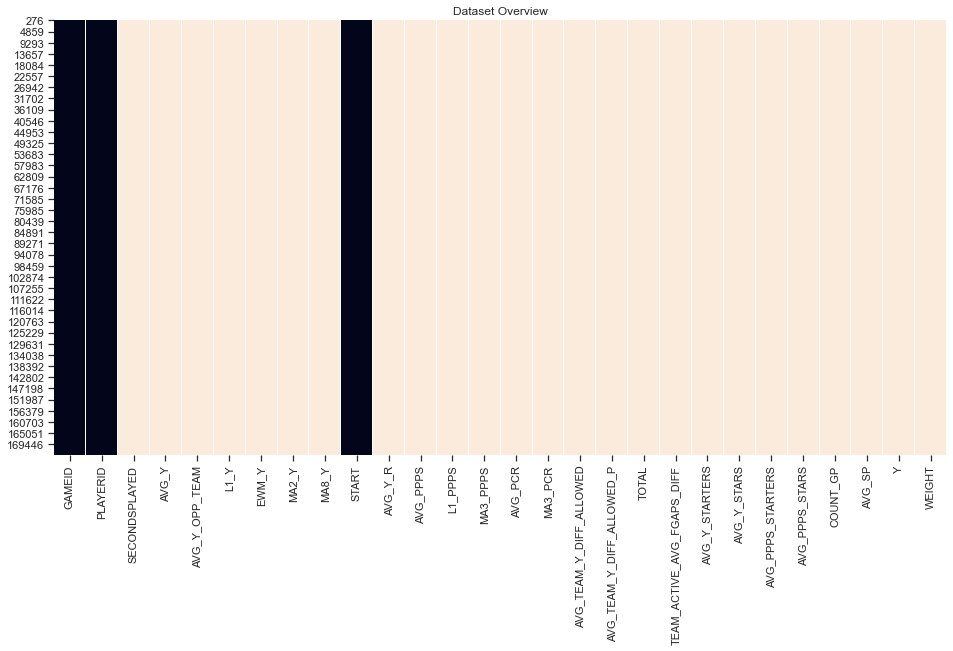

 Categerocial   Numeric   NaN 

Percentage of rows containing at least one missing value: 0.0


In [78]:
helpers.visualize_dataframe(feature_matrix)

# Model/Feature Selection
Finally, it's time to build the model. I will first iterate through various model types. Within each model iteration, I will isolate the important features. I will also try predicting the log transform of the dependant variable, and scaling the numeric columns, and pick whatever (Model, Feature Subset, \[Log Transform, No Transform\], \[Scale, No Scale\]) combination yeilds the lowest average MSE after 5-fold cross validation.

In [79]:
linear_models = [
    linear_model.LinearRegression(),
#     linear_model.Ridge(),
#     linear_model.ElasticNet()
]

neighbor_models = [
#     neighbors.KNeighborsRegressor()
]

boosted_models = [
    xgb.XGBRegressor(objective='reg:squarederror', eval_metric='mae', learning_rate=0.1, n_estimators=500, tree_method='hist'),
    CatBoostRegressor(eval_metric='MAE', learning_rate=0.1, n_estimators=500, silent=True)
    
]

neural_networks = [
    neural_network.MLPRegressor(max_iter=10000, early_stopping=True, random_state=42)
]

models = linear_models + neighbor_models + boosted_models + neural_networks

transformers = [
    {
        'Function': lambda x: x,
        'Inverse Function': lambda x: x,
        'Name': 'None'
    },
    {
        'Function': lambda x: np.log(x + 1),
        'Inverse Function': lambda x: np.exp(x) - 1,
        'Name': 'Log'
    }
]

numeric_regressors = list(set(regressors) - set(categorical_regressors))
numeric_columns = numeric_regressors + [y]

min_score = float('inf')
best_model = None
for model in models:
    for transformer in transformers:
        for scale in [False, True]:
            
            # transform numeric columns
            feature_matrix_t = feature_matrix.copy()
            feature_matrix_t[numeric_columns] = feature_matrix_t[numeric_columns].apply(
                transformer['Function'], axis=1
            )
            
            # scale numeric features
            if scale:
                x_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[numeric_regressors] = x_scaler.fit_transform(feature_matrix_t[numeric_regressors])
                
                y_scaler = preprocessing.RobustScaler(quantile_range=(25.0, 75.0))
                feature_matrix_t[[y]] = y_scaler.fit_transform(feature_matrix_t[[y]])

            # feature selection
            X = feature_matrix_t[regressors]
            Y = feature_matrix_t[y]
            W = feature_matrix_t[w]

            if model in (neighbor_models + neural_networks):
                selected_features = regressors.copy()
            else:
                model.fit(X, Y, sample_weight=W)
                
                # importance
                importance_selector = SelectFromModel(model, threshold='0.75*median')
                importance_selector = importance_selector.fit(X, Y, sample_weight=W)
                importance_support = importance_selector.get_support()
                
                # rank
                rank_selector = RFE(model)
                rank_selector = rank_selector.fit(X, Y)
                rank_support = rank_selector.ranking_
                median_rank = np.median(rank_support)
                
                selected_features = []
                for feature, importance_flag, rank in zip(list(X.columns), importance_support, rank_support):
                    # select the feature if it's important, or has a low rank
                    if importance_flag or (rank <= median_rank):
                        selected_features.append(feature)
            
            X = feature_matrix_t[selected_features].values
            Y = feature_matrix_t[y].values
            W = feature_matrix_t[w].values
            
            # cross validation
            scores = []
            cv = model_selection.KFold(n_splits=5, shuffle=True)
            for train, test in cv.split(X, Y, W):
                if model in (neural_networks + neighbor_models):
                    prediction = model.fit(X[train], Y[train]).predict(X[test])
                else:
                    prediction = model.fit(X[train], Y[train], sample_weight=W[train]).predict(X[test])
                true = Y[test]

                if scale:
                    prediction = y_scaler.inverse_transform(prediction.reshape(-1,1)).reshape(-1)
                    true = y_scaler.inverse_transform(true.reshape(-1,1)).reshape(-1)

                prediction = transformer['Inverse Function'](prediction)
                true = transformer['Inverse Function'](true)
                
                scores.append(metrics.mean_absolute_error(prediction, true, sample_weight=W[test]))

            mean_score = np.mean(scores)
            print('Model:', model)
            print('Transformer:', transformer['Name'])
            print('Scale:', scale)
            print('Selected Features:', selected_features)
            print('Mean MAE:', mean_score)
            print()
            if mean_score < min_score:
                min_score = mean_score
                best_model = (model, transformer['Name'], scale, selected_features)
print(best_model, min_score)

Model: LinearRegression()
Transformer: None
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_PPPS', 'MA3_PPPS', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_PPPS_STARTERS', 'AVG_PPPS_STARS']
Mean MAE: 0.0025798029277461195

Model: LinearRegression()
Transformer: None
Scale: True
Selected Features: ['AVG_Y', 'MA8_Y', 'START', 'AVG_Y_R', 'AVG_PPPS', 'MA3_PPPS', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_PPPS_STARTERS', 'AVG_PPPS_STARS', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0025781600176966223

Model: LinearRegression()
Transformer: Log
Scale: False
Selected Features: ['AVG_Y', 'L1_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_PPPS', 'MA3_PPPS', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_PPPS_STARTERS', 'AVG_PPPS_STARS']
Mean MAE: 0.00257952053268065

Model: Li

Model: MLPRegressor(early_stopping=True, max_iter=10000, random_state=42)
Transformer: Log
Scale: True
Selected Features: ['AVG_Y', 'AVG_Y_OPP_TEAM', 'L1_Y', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'START', 'AVG_Y_R', 'AVG_PPPS', 'L1_PPPS', 'MA3_PPPS', 'AVG_PCR', 'MA3_PCR', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TOTAL', 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_PPPS_STARTERS', 'AVG_PPPS_STARS', 'COUNT_GP', 'AVG_SP']
Mean MAE: 0.0025750234028037748

(<catboost.core.CatBoostRegressor object at 0x147124518>, 'None', False, ['AVG_Y', 'AVG_Y_OPP_TEAM', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_PPPS', 'MA3_PPPS', 'AVG_PCR', 'MA3_PCR', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P', 'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_PPPS_STARTERS', 'AVG_PPPS_STARS', 'COUNT_GP', 'AVG_SP']) 0.0025735234295475177


The best model is a Catboost model with no log transformations or scaling.

# Parameter Tuning
Now, I will use Grid Search Cross Validation to find the CatBoostRegressor paramters that yeild the lowest average MSE on the test set.

In [80]:
selected_features = ['AVG_Y', 'AVG_Y_OPP_TEAM', 'EWM_Y', 'MA2_Y', 'MA8_Y', 'AVG_Y_R', 'AVG_PPPS',
                     'MA3_PPPS', 'AVG_PCR', 'MA3_PCR', 'AVG_TEAM_Y_DIFF_ALLOWED', 'AVG_TEAM_Y_DIFF_ALLOWED_P',
                     'TEAM_ACTIVE_AVG_FGAPS_DIFF', 'AVG_Y_STARTERS', 'AVG_Y_STARS', 'AVG_PPPS_STARTERS',
                     'AVG_PPPS_STARS', 'COUNT_GP', 'AVG_SP']
# selected_features = best_model[3]
X = feature_matrix[selected_features]
Y = feature_matrix[y]
W = feature_matrix[w]
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(X, Y, W, test_size=0.25, random_state=1)

In [81]:
model = CatBoostRegressor()

model_params = {
    'depth': [4, 6, 8, 10],
    'learning_rate' : [0.01, 0.02, 0.05, 0.1],
    'num_boost_round': [5000],
    'eval_metric': ['MAE']
}

grid = GridSearchCV(estimator=model, param_grid=model_params, scoring='neg_mean_absolute_error', cv=2, n_jobs=-1)

fit_params = {
    "early_stopping_rounds": 25,
    "eval_set": (X_test, y_test),
    'sample_weight': w_train
}

grid.fit(X_train, y_train, **fit_params)    

print("\n========================================================")
print(" Results from Grid Search " )
print("========================================================")    

print("\n The best estimator across ALL searched params:\n", grid.best_estimator_)

print("\n The best score across ALL searched params:\n", grid.best_score_)

print("\n The best parameters across ALL searched params:\n", grid.best_params_)

print("\n ========================================================")

0:	learn: 0.0030525	test: 0.0034089	best: 0.0034089 (0)	total: 68.3ms	remaining: 5m 41s
1:	learn: 0.0030366	test: 0.0033941	best: 0.0033941 (1)	total: 133ms	remaining: 5m 31s
2:	learn: 0.0030211	test: 0.0033797	best: 0.0033797 (2)	total: 189ms	remaining: 5m 14s
3:	learn: 0.0030063	test: 0.0033659	best: 0.0033659 (3)	total: 270ms	remaining: 5m 37s
4:	learn: 0.0029918	test: 0.0033522	best: 0.0033522 (4)	total: 364ms	remaining: 6m 3s
5:	learn: 0.0029777	test: 0.0033389	best: 0.0033389 (5)	total: 433ms	remaining: 6m
6:	learn: 0.0029642	test: 0.0033264	best: 0.0033264 (6)	total: 500ms	remaining: 5m 56s
7:	learn: 0.0029513	test: 0.0033143	best: 0.0033143 (7)	total: 585ms	remaining: 6m 5s
8:	learn: 0.0029386	test: 0.0033025	best: 0.0033025 (8)	total: 645ms	remaining: 5m 57s
9:	learn: 0.0029263	test: 0.0032908	best: 0.0032908 (9)	total: 717ms	remaining: 5m 57s
10:	learn: 0.0029146	test: 0.0032798	best: 0.0032798 (10)	total: 807ms	remaining: 6m 5s
11:	learn: 0.0029030	test: 0.0032688	best: 0.00

93:	learn: 0.0025854	test: 0.0029696	best: 0.0029696 (93)	total: 6.71s	remaining: 5m 50s
94:	learn: 0.0025846	test: 0.0029688	best: 0.0029688 (94)	total: 6.76s	remaining: 5m 49s
95:	learn: 0.0025839	test: 0.0029681	best: 0.0029681 (95)	total: 6.84s	remaining: 5m 49s
96:	learn: 0.0025831	test: 0.0029673	best: 0.0029673 (96)	total: 6.9s	remaining: 5m 48s
97:	learn: 0.0025823	test: 0.0029667	best: 0.0029667 (97)	total: 6.97s	remaining: 5m 48s
98:	learn: 0.0025815	test: 0.0029660	best: 0.0029660 (98)	total: 7.07s	remaining: 5m 50s
99:	learn: 0.0025807	test: 0.0029653	best: 0.0029653 (99)	total: 7.12s	remaining: 5m 48s
100:	learn: 0.0025800	test: 0.0029646	best: 0.0029646 (100)	total: 7.21s	remaining: 5m 49s
101:	learn: 0.0025792	test: 0.0029639	best: 0.0029639 (101)	total: 7.26s	remaining: 5m 48s
102:	learn: 0.0025785	test: 0.0029632	best: 0.0029632 (102)	total: 7.33s	remaining: 5m 48s
103:	learn: 0.0025778	test: 0.0029626	best: 0.0029626 (103)	total: 7.4s	remaining: 5m 48s
104:	learn: 0.0

187:	learn: 0.0025464	test: 0.0029395	best: 0.0029395 (187)	total: 13.4s	remaining: 5m 42s
188:	learn: 0.0025462	test: 0.0029394	best: 0.0029394 (188)	total: 13.5s	remaining: 5m 43s
189:	learn: 0.0025459	test: 0.0029393	best: 0.0029393 (189)	total: 13.5s	remaining: 5m 43s
190:	learn: 0.0025457	test: 0.0029391	best: 0.0029391 (190)	total: 13.6s	remaining: 5m 42s
191:	learn: 0.0025455	test: 0.0029390	best: 0.0029390 (191)	total: 13.7s	remaining: 5m 42s
192:	learn: 0.0025452	test: 0.0029389	best: 0.0029389 (192)	total: 13.7s	remaining: 5m 42s
193:	learn: 0.0025450	test: 0.0029388	best: 0.0029388 (193)	total: 13.8s	remaining: 5m 42s
194:	learn: 0.0025447	test: 0.0029388	best: 0.0029388 (194)	total: 13.9s	remaining: 5m 41s
195:	learn: 0.0025445	test: 0.0029386	best: 0.0029386 (195)	total: 14s	remaining: 5m 42s
196:	learn: 0.0025443	test: 0.0029386	best: 0.0029386 (196)	total: 14s	remaining: 5m 42s
197:	learn: 0.0025439	test: 0.0029384	best: 0.0029384 (197)	total: 14.2s	remaining: 5m 43s
198

279:	learn: 0.0025280	test: 0.0029337	best: 0.0029337 (279)	total: 20.5s	remaining: 5m 45s
280:	learn: 0.0025278	test: 0.0029336	best: 0.0029336 (280)	total: 20.5s	remaining: 5m 44s
281:	learn: 0.0025277	test: 0.0029335	best: 0.0029335 (281)	total: 20.6s	remaining: 5m 45s
282:	learn: 0.0025275	test: 0.0029335	best: 0.0029335 (282)	total: 20.7s	remaining: 5m 45s
283:	learn: 0.0025273	test: 0.0029334	best: 0.0029334 (283)	total: 20.8s	remaining: 5m 44s
284:	learn: 0.0025271	test: 0.0029334	best: 0.0029334 (284)	total: 20.8s	remaining: 5m 44s
285:	learn: 0.0025270	test: 0.0029334	best: 0.0029334 (285)	total: 20.9s	remaining: 5m 44s
286:	learn: 0.0025268	test: 0.0029334	best: 0.0029334 (286)	total: 21s	remaining: 5m 44s
287:	learn: 0.0025267	test: 0.0029334	best: 0.0029334 (287)	total: 21s	remaining: 5m 44s
288:	learn: 0.0025265	test: 0.0029333	best: 0.0029333 (288)	total: 21.1s	remaining: 5m 44s
289:	learn: 0.0025262	test: 0.0029332	best: 0.0029332 (289)	total: 21.2s	remaining: 5m 44s
290

370:	learn: 0.0025115	test: 0.0029319	best: 0.0029319 (369)	total: 27s	remaining: 5m 36s
371:	learn: 0.0025113	test: 0.0029318	best: 0.0029318 (371)	total: 27.1s	remaining: 5m 36s
372:	learn: 0.0025112	test: 0.0029318	best: 0.0029318 (371)	total: 27.1s	remaining: 5m 36s
373:	learn: 0.0025110	test: 0.0029318	best: 0.0029318 (371)	total: 27.2s	remaining: 5m 36s
374:	learn: 0.0025109	test: 0.0029318	best: 0.0029318 (371)	total: 27.3s	remaining: 5m 36s
375:	learn: 0.0025107	test: 0.0029318	best: 0.0029318 (375)	total: 27.4s	remaining: 5m 36s
376:	learn: 0.0025106	test: 0.0029318	best: 0.0029318 (376)	total: 27.4s	remaining: 5m 36s
377:	learn: 0.0025105	test: 0.0029318	best: 0.0029318 (376)	total: 27.5s	remaining: 5m 36s
378:	learn: 0.0025104	test: 0.0029318	best: 0.0029318 (378)	total: 27.6s	remaining: 5m 35s
379:	learn: 0.0025101	test: 0.0029317	best: 0.0029317 (379)	total: 27.6s	remaining: 5m 35s
380:	learn: 0.0025098	test: 0.0029317	best: 0.0029317 (380)	total: 27.7s	remaining: 5m 35s
3

461:	learn: 0.0024961	test: 0.0029306	best: 0.0029305 (450)	total: 33.5s	remaining: 5m 28s
462:	learn: 0.0024960	test: 0.0029306	best: 0.0029305 (450)	total: 33.5s	remaining: 5m 28s
463:	learn: 0.0024956	test: 0.0029305	best: 0.0029305 (450)	total: 33.6s	remaining: 5m 28s
464:	learn: 0.0024955	test: 0.0029306	best: 0.0029305 (450)	total: 33.6s	remaining: 5m 28s
465:	learn: 0.0024954	test: 0.0029306	best: 0.0029305 (450)	total: 33.7s	remaining: 5m 28s
466:	learn: 0.0024953	test: 0.0029306	best: 0.0029305 (450)	total: 33.8s	remaining: 5m 28s
467:	learn: 0.0024951	test: 0.0029306	best: 0.0029305 (450)	total: 33.9s	remaining: 5m 28s
468:	learn: 0.0024949	test: 0.0029306	best: 0.0029305 (450)	total: 34s	remaining: 5m 28s
469:	learn: 0.0024949	test: 0.0029306	best: 0.0029305 (450)	total: 34s	remaining: 5m 28s
470:	learn: 0.0024947	test: 0.0029306	best: 0.0029305 (450)	total: 34.1s	remaining: 5m 28s
471:	learn: 0.0024945	test: 0.0029306	best: 0.0029305 (450)	total: 34.2s	remaining: 5m 27s
472

# Evaluation
Lastly, I will evaluate the final model.

In [82]:
best_params = grid.best_params_
model = CatBoostRegressor(**best_params)

weighted_eval_set = Pool(
    data=X_test,
    label=y_test,
    weight=w_test
)
fit_params['eval_set'] = weighted_eval_set

model.fit(X_train, y_train, **fit_params)

y_hat = model.predict(X_test)

0:	learn: 0.0030525	test: 0.0030513	best: 0.0030513 (0)	total: 75.9ms	remaining: 6m 19s
1:	learn: 0.0030366	test: 0.0030356	best: 0.0030356 (1)	total: 161ms	remaining: 6m 42s
2:	learn: 0.0030211	test: 0.0030203	best: 0.0030203 (2)	total: 206ms	remaining: 5m 43s
3:	learn: 0.0030063	test: 0.0030056	best: 0.0030056 (3)	total: 301ms	remaining: 6m 15s
4:	learn: 0.0029918	test: 0.0029912	best: 0.0029912 (4)	total: 375ms	remaining: 6m 14s
5:	learn: 0.0029777	test: 0.0029772	best: 0.0029772 (5)	total: 430ms	remaining: 5m 57s
6:	learn: 0.0029642	test: 0.0029639	best: 0.0029639 (6)	total: 514ms	remaining: 6m 6s
7:	learn: 0.0029513	test: 0.0029509	best: 0.0029509 (7)	total: 587ms	remaining: 6m 6s
8:	learn: 0.0029386	test: 0.0029384	best: 0.0029384 (8)	total: 653ms	remaining: 6m 2s
9:	learn: 0.0029263	test: 0.0029260	best: 0.0029260 (9)	total: 723ms	remaining: 6m
10:	learn: 0.0029146	test: 0.0029144	best: 0.0029144 (10)	total: 792ms	remaining: 5m 59s
11:	learn: 0.0029030	test: 0.0029029	best: 0.00

93:	learn: 0.0025854	test: 0.0025973	best: 0.0025973 (93)	total: 6.59s	remaining: 5m 44s
94:	learn: 0.0025846	test: 0.0025966	best: 0.0025966 (94)	total: 6.65s	remaining: 5m 43s
95:	learn: 0.0025839	test: 0.0025960	best: 0.0025960 (95)	total: 6.71s	remaining: 5m 42s
96:	learn: 0.0025831	test: 0.0025953	best: 0.0025953 (96)	total: 6.78s	remaining: 5m 42s
97:	learn: 0.0025823	test: 0.0025947	best: 0.0025947 (97)	total: 6.86s	remaining: 5m 42s
98:	learn: 0.0025815	test: 0.0025941	best: 0.0025941 (98)	total: 6.94s	remaining: 5m 43s
99:	learn: 0.0025807	test: 0.0025936	best: 0.0025936 (99)	total: 7.02s	remaining: 5m 43s
100:	learn: 0.0025800	test: 0.0025930	best: 0.0025930 (100)	total: 7.06s	remaining: 5m 42s
101:	learn: 0.0025792	test: 0.0025923	best: 0.0025923 (101)	total: 7.16s	remaining: 5m 43s
102:	learn: 0.0025785	test: 0.0025918	best: 0.0025918 (102)	total: 7.21s	remaining: 5m 42s
103:	learn: 0.0025778	test: 0.0025913	best: 0.0025913 (103)	total: 7.31s	remaining: 5m 44s
104:	learn: 0

185:	learn: 0.0025468	test: 0.0025745	best: 0.0025745 (185)	total: 13.1s	remaining: 5m 39s
186:	learn: 0.0025466	test: 0.0025744	best: 0.0025744 (186)	total: 13.2s	remaining: 5m 39s
187:	learn: 0.0025464	test: 0.0025744	best: 0.0025744 (187)	total: 13.2s	remaining: 5m 39s
188:	learn: 0.0025462	test: 0.0025743	best: 0.0025743 (188)	total: 13.3s	remaining: 5m 38s
189:	learn: 0.0025459	test: 0.0025742	best: 0.0025742 (189)	total: 13.4s	remaining: 5m 38s
190:	learn: 0.0025457	test: 0.0025742	best: 0.0025742 (190)	total: 13.4s	remaining: 5m 38s
191:	learn: 0.0025455	test: 0.0025741	best: 0.0025741 (191)	total: 13.5s	remaining: 5m 38s
192:	learn: 0.0025452	test: 0.0025740	best: 0.0025740 (192)	total: 13.6s	remaining: 5m 38s
193:	learn: 0.0025450	test: 0.0025740	best: 0.0025740 (193)	total: 13.7s	remaining: 5m 38s
194:	learn: 0.0025447	test: 0.0025739	best: 0.0025739 (194)	total: 13.7s	remaining: 5m 38s
195:	learn: 0.0025445	test: 0.0025738	best: 0.0025738 (195)	total: 13.8s	remaining: 5m 38s

276:	learn: 0.0025286	test: 0.0025715	best: 0.0025715 (276)	total: 19.4s	remaining: 5m 31s
277:	learn: 0.0025284	test: 0.0025714	best: 0.0025714 (277)	total: 19.5s	remaining: 5m 31s
278:	learn: 0.0025282	test: 0.0025714	best: 0.0025714 (278)	total: 19.6s	remaining: 5m 31s
279:	learn: 0.0025280	test: 0.0025714	best: 0.0025714 (279)	total: 19.7s	remaining: 5m 31s
280:	learn: 0.0025278	test: 0.0025714	best: 0.0025714 (280)	total: 19.7s	remaining: 5m 31s
281:	learn: 0.0025277	test: 0.0025713	best: 0.0025713 (281)	total: 19.8s	remaining: 5m 31s
282:	learn: 0.0025275	test: 0.0025713	best: 0.0025713 (282)	total: 19.8s	remaining: 5m 30s
283:	learn: 0.0025273	test: 0.0025713	best: 0.0025713 (283)	total: 19.9s	remaining: 5m 30s
284:	learn: 0.0025271	test: 0.0025713	best: 0.0025713 (283)	total: 20s	remaining: 5m 30s
285:	learn: 0.0025270	test: 0.0025713	best: 0.0025713 (283)	total: 20.1s	remaining: 5m 30s
286:	learn: 0.0025268	test: 0.0025713	best: 0.0025713 (286)	total: 20.1s	remaining: 5m 30s
2

367:	learn: 0.0025122	test: 0.0025709	best: 0.0025708 (355)	total: 25.9s	remaining: 5m 25s
368:	learn: 0.0025120	test: 0.0025709	best: 0.0025708 (355)	total: 25.9s	remaining: 5m 25s
369:	learn: 0.0025118	test: 0.0025709	best: 0.0025708 (355)	total: 26s	remaining: 5m 25s
370:	learn: 0.0025115	test: 0.0025709	best: 0.0025708 (355)	total: 26.1s	remaining: 5m 25s
371:	learn: 0.0025113	test: 0.0025708	best: 0.0025708 (355)	total: 26.1s	remaining: 5m 25s
372:	learn: 0.0025112	test: 0.0025708	best: 0.0025708 (355)	total: 26.2s	remaining: 5m 25s
373:	learn: 0.0025110	test: 0.0025708	best: 0.0025708 (355)	total: 26.3s	remaining: 5m 24s
374:	learn: 0.0025109	test: 0.0025709	best: 0.0025708 (355)	total: 26.3s	remaining: 5m 24s
375:	learn: 0.0025107	test: 0.0025709	best: 0.0025708 (355)	total: 26.4s	remaining: 5m 24s
376:	learn: 0.0025106	test: 0.0025709	best: 0.0025708 (355)	total: 26.5s	remaining: 5m 25s
377:	learn: 0.0025105	test: 0.0025709	best: 0.0025708 (355)	total: 26.6s	remaining: 5m 24s
3

First, I will visualize the feature importances.

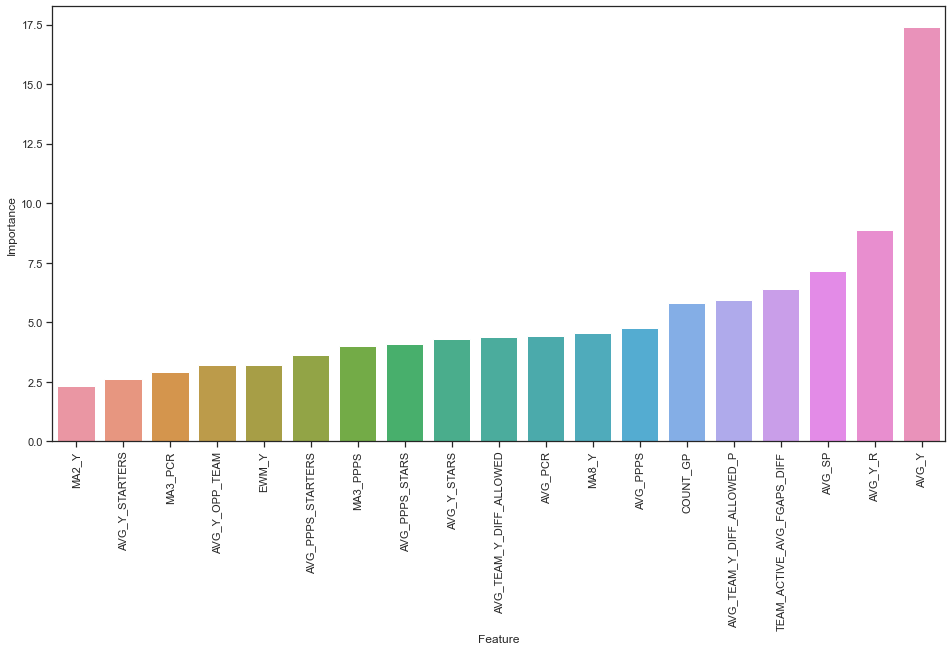

In [83]:
feature_importances = model.feature_importances_
feature_importance_df = pd.DataFrame({'Importance': feature_importances, 'Feature': selected_features})
feature_importance_df = feature_importance_df.sort_values(by='Importance')
ax = sns.barplot(x="Feature", y="Importance", data=feature_importance_df)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
plt.show()

I will calculate a few metrics to evaluate the model's predictive power.

In [84]:
y_avg = feature_matrix.loc[X_test.index, 'AVG_Y']

# Kpi
print("R2 (explained variance):")
print("Model:", round(metrics.r2_score(y_test, y_hat, sample_weight=w_test), 3))
print("Baseline:", round(metrics.r2_score(y_test, y_avg, sample_weight=w_test), 3))

print("\nMean Absolute Error (Σ|y-pred|/n):")
print("Model:", round(metrics.mean_absolute_error(y_test, y_hat, sample_weight=w_test), 6))
print("Baseline:", round(metrics.mean_absolute_error(y_test, y_avg, sample_weight=w_test), 6))

print("\nRoot Mean Squared Error (sqrt(Σ(y-pred)^2/n)):")
print("Model:", round(np.sqrt(metrics.mean_squared_error(y_test, y_hat, sample_weight=w_test)), 6))
print("Baseline:", round(np.sqrt(metrics.mean_squared_error(y_test, y_avg, sample_weight=w_test)), 6))

R2 (explained variance):
Model: 0.286
Baseline: 0.264

Mean Absolute Error (Σ|y-pred|/n):
Model: 0.002572
Baseline: 0.002601

Root Mean Squared Error (sqrt(Σ(y-pred)^2/n)):
Model: 0.003264
Baseline: 0.003313


Residual analysis:

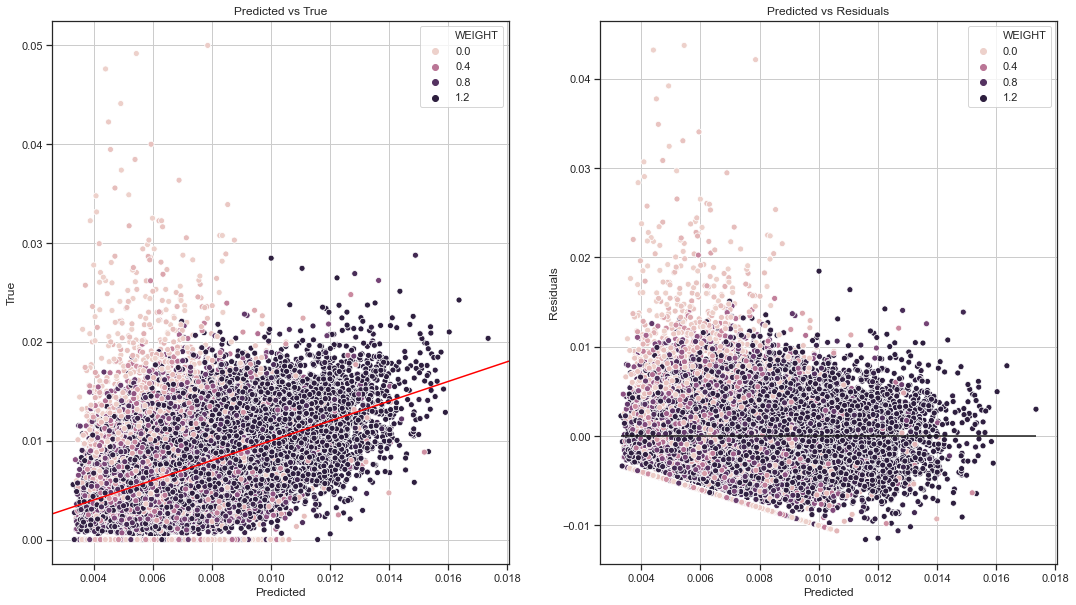

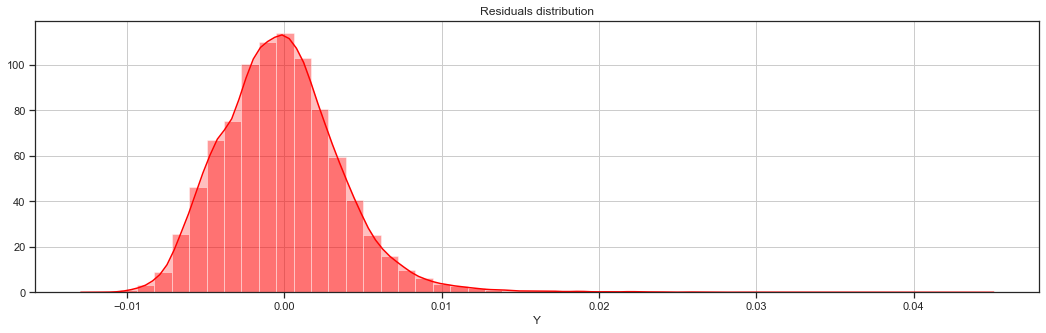

In [85]:
residuals = y_test - y_hat

# plot predicted vs true
fig, ax = plt.subplots(nrows=1, ncols=2, figsize=(18, 10))
sns.scatterplot(y_hat, y_test, hue=w_test, ax=ax[0])
abline_plot(intercept=0, slope=1, color="red", ax=ax[0])
ax[0].grid(True)
ax[0].set(xlabel="Predicted", ylabel="True", title="Predicted vs True")
ax[0].legend()
    
# plot predicted vs residuals
sns.scatterplot(y_hat, residuals, hue=w_test, ax=ax[1])
ax[1].grid(True)
ax[1].set(xlabel="Predicted", ylabel="Residuals", title="Predicted vs Residuals")
ax[1].hlines(y=0, xmin=np.min(y_hat), xmax=np.max(y_hat))
ax[1].legend()
plt.show()

fig, ax = plt.subplots(figsize=(18, 5))
sns.distplot(residuals, color="red", hist=True, kde=True, kde_kws={"shade":True}, ax=ax)
ax.grid(True)
ax.set(title="Residuals distribution")
plt.show()

In [86]:
stat, p = shapiro(residuals)
print(stat, p)

0.9563555121421814 0.0


Residuals are normally distributed and not heteroskedastic.

# Investigation

Let's look at specific situations in which we know defense and injuries should be a factor.

The Lakers are elite at defending the center position in the 2019-20 season.

In [87]:
feature_matrix['Y_HAT'] = model.predict(feature_matrix[selected_features])

,DATE,NAME,START,Y_HAT,Y,AVG_Y,SECONDSPLAYED,SUM_SP,WEIGHT
141821,2020-02-04,LaMarcus Aldridge,1,0.008793,0.003863,0.009606,1812,89217.0,0.941917
141844,2020-02-04,Jakob Poeltl,0,0.005449,0.007426,0.005195,808,51584.0,0.531926
143082,2020-02-12,Nikola Jokic,1,0.010745,0.009830,0.010589,2238,105110.0,0.949113
143402,2020-02-21,Gorgui Dieng,0,0.005275,0.011138,0.004531,1257,48231.0,0.859140
143417,2020-02-21,Jonas Valanciunas,1,0.008802,0.005544,0.009476,1443,80836.0,0.908218
143584,2020-02-23,Enes Kanter,0,0.007452,0.000000,0.008103,310,47515.0,0.109391
144000,2020-02-25,Jahlil Okafor,0,0.007875,0.000000,0.008497,266,25186.0,0.090458
144598,2020-02-29,Jonas Valanciunas,1,0.008800,0.011911,0.009275,1847,87112.0,0.943130
144607,2020-02-29,Gorgui Dieng,0,0.006384,0.001576,0.007147,1269,53682.0,0.863451
145091,2020-03-03,Al Horford,1,0.006579,0.004026,0.006361,1987,102817.0,0.946484


,DATE,NAME,START,Y_HAT,Y,AVG_Y,SECONDSPLAYED,SUM_SP,WEIGHT
146162,2020-03-10,Jarrett Allen,0,0.00654,0.002427,0.006947,1236,97601.0,0.851136


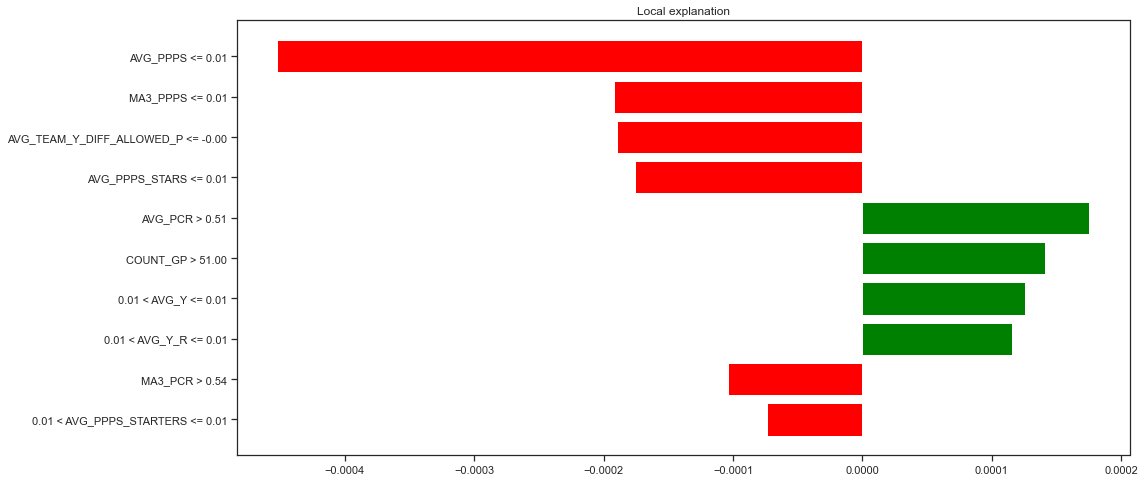

In [88]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'DATE', 'NAME', 'OPP_TEAM', 'NORM_POS', 'SEASON', 'SUM_SP']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['OPP_TEAM'] == 'LAL') & (temp['NORM_POS'] == 'Center') & (temp['SEASON'] == '2019-20')]
idx = temp.index[-1]

display(temp.loc[temp.index[-15:]][['DATE', 'NAME', 'START', 'Y_HAT', 'Y', 'AVG_Y', 'SECONDSPLAYED', 'SUM_SP'] + [w]])
print()
display(temp.loc[[idx]][['DATE', 'NAME', 'START', 'Y_HAT', 'Y', 'AVG_Y', 'SECONDSPLAYED', 'SUM_SP'] + [w]])

explainer = lime_tabular.LimeTabularExplainer(training_data=feature_matrix[selected_features].values, feature_names=selected_features, class_names='Y', mode="regression")

explained = explainer.explain_instance(temp.loc[idx, selected_features].values, model.predict, num_features=10)
explained.as_pyplot_figure()
plt.show()
plt.close()

In [89]:
def_std = feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'].std()

good_d = feature_matrix.loc[feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] < -2*def_std]
bad_d = feature_matrix.loc[feature_matrix['AVG_TEAM_Y_DIFF_ALLOWED_P'] > 2*def_std]

print("Mean Error (Σ(y-pred)/n):")

print("\nOverall Model:", round( ((feature_matrix['Y_HAT'] - feature_matrix['Y']) * feature_matrix[w]).sum()/feature_matrix[w].sum() , 8))

print("\nFacing Good Defense:")
print("Model:", round( ((good_d['Y_HAT'] - good_d['Y']) * good_d[w]).sum()/good_d[w].sum() , 8))
print("Baseline:", round( ((good_d['AVG_Y'] - good_d['Y']) * good_d[w]).sum()/good_d[w].sum() , 8))

print("\nFacing Bad Defense:")
print("Model:", round( ((bad_d['Y_HAT'] - bad_d['Y']) * bad_d[w]).sum()/bad_d[w].sum() , 8))
print("Baseline:", round( ((bad_d['AVG_Y'] - bad_d['Y']) * bad_d[w]).sum()/bad_d[w].sum() , 8))

Mean Error (Σ(y-pred)/n):

Overall Model: 3e-06

Facing Good Defense:
Model: 2.913e-05
Baseline: 0.0003634

Facing Bad Defense:
Model: -5.608e-05
Baseline: -0.00032618


Overall, the model seems to be making adjustments for the defense. The mean error of the model is close to 0 when facing good and bad defenses, while $AVG\_Y$ overestimates $Y$ when the defense is good and underestimates $Y$ when the defense is bad.

What about injuries? Russell Westbrook went off in the 2014-2015 season after Kevin Durant got injured in late February.

,SEASON,DATE,NAME,AVG_Y,Y,Y_HAT,STARS,SECONDSPLAYED,SUM_SP,WEIGHT
14682,2014-15,2015-02-02,Russell Westbrook,0.012875,0.010865,0.012782,201566,2301,63691.0,0.949427
15005,2014-15,2015-02-04,Russell Westbrook,0.012805,0.018534,0.012370,201566,2428,65992.0,0.949846
15350,2014-15,2015-02-06,Russell Westbrook,0.013008,0.020151,0.012732,201142_201566,2382,68420.0,0.949721
15558,2014-15,2015-02-08,Russell Westbrook,0.013248,0.010053,0.012700,201142_201566,1890,70802.0,0.944387
15894,2014-15,2015-02-09,Russell Westbrook,0.013165,0.013416,0.013254,201142_201566,1938,72692.0,0.945536
16176,2014-15,2015-02-11,Russell Westbrook,0.013172,0.012339,0.012031,201142_201566,1945,74630.0,0.945684
16317,2014-15,2015-02-19,Russell Westbrook,0.013151,0.015880,0.013088,201142_201566,2141,76575.0,0.948421
16610,2014-15,2015-02-21,Russell Westbrook,0.013225,0.015500,0.012786,201566,2129,78716.0,0.948313
16819,2014-15,2015-02-22,Russell Westbrook,0.013285,0.012781,0.014022,201566,1643,80845.0,0.932598
17098,2014-15,2015-02-24,Russell Westbrook,0.013275,0.011799,0.013617,201566,1695,82488.0,0.936217


,SEASON,DATE,NAME,AVG_Y,Y,Y_HAT,STARS,SECONDSPLAYED,SUM_SP,WEIGHT
19050,2014-15,2015-03-08,Russell Westbrook,0.013707,0.012469,0.015277,201566,2406,93821.0,0.94979


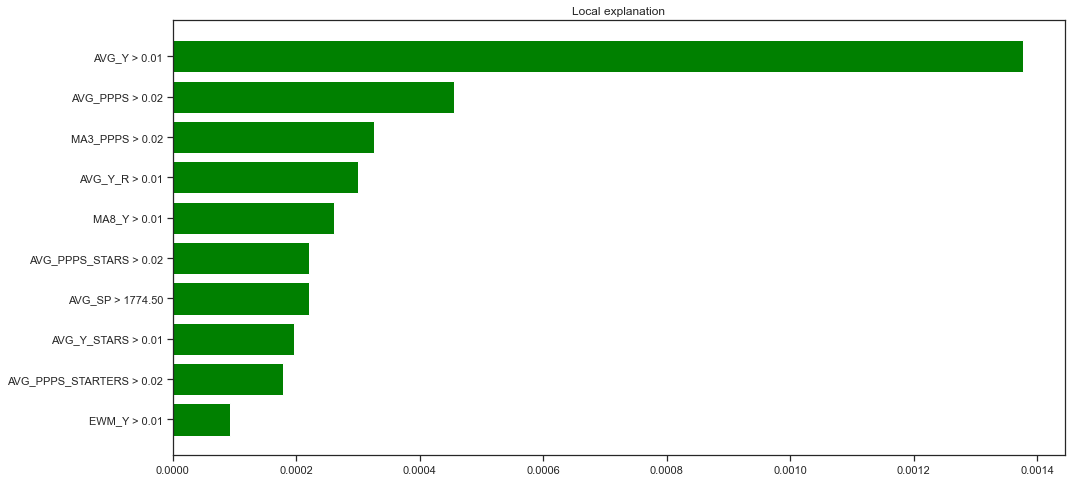

In [90]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'DATE', 'NAME', 'SEASON', 'STARS', 'SUM_SP']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['NAME'] == 'Russell Westbrook') & (temp['DATE'] >= '2015-02-01')]
idx = temp.index[14]

display(temp.loc[temp.index[0:15]][['SEASON', 'DATE', 'NAME', 'AVG_Y', 'Y', 'Y_HAT', 'STARS', 'SECONDSPLAYED', 'SUM_SP'] + [w]])
print()
display(temp.loc[[idx]][['SEASON', 'DATE', 'NAME', 'AVG_Y', 'Y', 'Y_HAT', 'STARS', 'SECONDSPLAYED', 'SUM_SP'] + [w]])

explainer = lime_tabular.LimeTabularExplainer(training_data=feature_matrix[selected_features].values, feature_names=selected_features, class_names='Y', mode="regression")

explained = explainer.explain_instance(temp.loc[idx, selected_features].values, model.predict, num_features=10)
explained.as_pyplot_figure()
plt.show()
plt.close()

In [91]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'NAME', 'SEASON', 'STARS']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['SEASON']=='2014-15') & (temp['NAME'] == 'Russell Westbrook')]

kd_out = temp.loc[temp['STARS'] == '201566']
kd_in = temp.loc[temp['STARS'] == '201142_201566']

print("Mean Error (Σ(y-pred)/n):")

print("\nAVG Y_HAT When KD Out:", round( kd_out['Y_HAT'].mean() , 8))
print("AVG Y When KD Out:", round( kd_out['Y'].mean() , 8))

print("\nAVG Y_HAT When KD In:", round( kd_in['Y_HAT'].mean() , 8))
print("AVG Y When KD In:", round( kd_in['Y'].mean() , 8))

Mean Error (Σ(y-pred)/n):

AVG Y_HAT When KD Out: 0.01352269
AVG Y When KD Out: 0.01380292

AVG Y_HAT When KD In: 0.0122622
AVG Y When KD In: 0.01252953


The model seems to appropriately adjust for the injury.

In [92]:
temp = feature_matrix.merge(
    boxscores[['GAMEID', 'PLAYERID', 'NAME', 'SEASON', 'DATE', 'NORM_POS', 'SUM_SP']],
    on=['GAMEID', 'PLAYERID'], how='left'
)

temp = temp.loc[(temp['NAME'] == 'James Harden') & (temp['SEASON'] == '2018-19')]

temp['MODEL_RESIDUAL'] = temp['Y'] - temp['Y_HAT']
temp['BASELINE_RESIDUAL'] = temp['Y'] - temp['AVG_Y']

print(temp['MODEL_RESIDUAL'].mean(), temp['BASELINE_RESIDUAL'].mean())
print(temp['MODEL_RESIDUAL'].abs().mean(), temp['BASELINE_RESIDUAL'].abs().mean())

0.0016723563806320266 0.0014528218676142638
0.002941947335611132 0.0031523406959524385


In [2]:
from pyNBA.Data.data import QueryData
query_data = QueryData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

/Users/brandonshimiaie/Projects/pyNBA/sqlite/db/nba.db
2.6.0


In [6]:
# pd.set_option('display.max_columns', None)
display(boxscores[['SECONDSPLAYED', 'OREB', 'OREB_PCT']])

,SECONDSPLAYED,OREB,OREB_PCT
0,760,0,0.000
1,908,0,0.000
2,1134,0,0.000
3,1005,0,0.000
4,912,2,0.083
...,...,...,...
180619,133,0,0.000
180620,280,0,0.000
180621,281,0,0.000
180622,436,0,0.000


In [ ]:
from pyNBA.Data.data import QueryData

query_data = QueryData()
clean_data = CleanData()

# pull boxscore data
boxscores = query_data.query_boxscore_data()

In [6]:
from nba_api.stats.endpoints import TeamDashPtPass

data = TeamDashPtPass(team_id="1610612761", opponent_team_id="1610612748", last_n_games="1", league_id="00", month="6",  per_mode_simple="Totals", season="2018-19", season_type_all_star="Regular Season", outcome_nullable="W", location_nullable="Home", vs_conference_nullable="East", season_segment_nullable="Post All-Star", vs_division_nullable="East", date_from_nullable="04/28/2020", date_to_nullable="04/29/2020")


In [7]:
df = data.get_data_frames()
display(df)

[Empty DataFrame
 Columns: [TEAM_ID, TEAM_NAME, PASS_TYPE, G, PASS_FROM, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG3M, FG3A, FG3_PCT]
 Index: [],
 Empty DataFrame
 Columns: [TEAM_ID, TEAM_NAME, PASS_TYPE, G, PASS_TO, PASS_TEAMMATE_PLAYER_ID, FREQUENCY, PASS, AST, FGM, FGA, FG_PCT, FG2M, FG2A, FG2_PCT, FG3M, FG3A, FG3_PCT]
 Index: []]